# Construction of Route Graphs

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate
import cvxpy as cp
from functools import reduce

### Load Json

In [2]:
scenario = "02_a_little_less_dummy.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [3]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

#get resources
resources = {}
for resource in scenario['resources']:
    idx = resource['id']
    if idx in resources:
        print('something is wrong')
    resources[idx] = resource['release_time']

### Printing of nodes

In [4]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [5]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [6]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
                
            if 'resource_occupations' in route_section:
                resource_occupations = {}
                for resource in route_section['resource_occupations']:
                    idx = resource['resource']
                    R = resources[idx]
                    resource_occupations[idx] = R
                    #maximum? code below
                    R=[isodate.parse_duration(value).seconds for key,value in resource_occupations.items()]
            edge_data['resource_occupations'] = resource_occupations
            edge_data['R'] = max(R)
            
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                try:
                    section_marker = route_section['section_marker'][0]
                except:
                    pass
            edge_data['section_marker'] = section_marker
            
            
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 2408
new route
Adding Edge from (1_beginning) to (1->5) with sequence number 1
{'penalty': None, 'minimum_running_time': 'PT1M40S', 'resource_occupations': {'ZGPP_1': 'PT10S', 'ZG_83': 'PT10S', 'ZG_3': 'PT10S'}, 'R': 10, 'section_marker': 'ZGPP', 'start_end': 'start', 'entry_earliest': '06:20:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 1}
Adding Edge from (1->5) to (5->10) with sequence number 5
{'penalty': None, 'minimum_running_time': 'PT42S', 'resource_occupations': {'ZG_83': 'PT10S', 'ZG_3': 'PT10S'}, 'R': 10, 'section_marker': 'ZG-ZGSE39', 'sequence_number': 5}
Adding Edge from (5->10) to (10->12) with sequence number 10
{'penalty': None, 'minimum_running_time': 'PT20S', 'resource_occupations': {'ZG_3': 'PT10S'}, 'R': 10, 'section_marker': 'ZG80', 'sequence_number': 10}
Adding Edge from (10->12) to (12->15) with sequence number 12
{'penalty': None, 'minimum_running_time': 'PT10S', 'resource_occupations': {'ZG_3': 'PT

Adding Edge from (560->565) to (565->570) with sequence number 565
{'penalty': None, 'minimum_running_time': 'PT23S', 'resource_occupations': {'AU_23': 'PT10S', 'AU-HG_219': 'PT30S', 'AU-HG_218': 'PT30S', 'HG_93': 'PT10S', 'HG_3': 'PT10S'}, 'R': 30, 'section_marker': 'AU', 'sequence_number': 565}
Adding Edge from (565->570) to (570->575) with sequence number 570
{'penalty': None, 'minimum_running_time': 'PT7S', 'resource_occupations': {'AU-HG_219': 'PT30S', 'AU-HG_218': 'PT30S', 'HG_93': 'PT10S', 'HG_3': 'PT10S'}, 'R': 30, 'section_marker': 'AUW', 'sequence_number': 570}
Adding Edge from (570->575) to (575->580) with sequence number 575
{'penalty': None, 'minimum_running_time': 'PT46S', 'resource_occupations': {'AU-HG_218': 'PT30S', 'HG_93': 'PT10S', 'HG_3': 'PT10S', 'HG_23': 'PT10S', 'HG-ORD_213': 'PT30S'}, 'R': 30, 'section_marker': 'HG-AU19', 'sequence_number': 575}
Adding Edge from (575->580) to (580->585) with sequence number 580
{'penalty': None, 'minimum_running_time': 'PT43S', 

{'penalty': None, 'minimum_running_time': 'PT12S', 'resource_occupations': {'BIL_23': 'PT10S', 'BIL-RG_253': 'PT30S'}, 'R': 30, 'section_marker': 'BIL', 'sequence_number': 335}
Adding Edge from (335->340) to (340->345) with sequence number 340
{'penalty': None, 'minimum_running_time': 'PT10S', 'resource_occupations': {'BIL-RG_253': 'PT30S', 'BIL-RG_252': 'PT30S'}, 'R': 30, 'section_marker': 'BILW', 'sequence_number': 340}
Adding Edge from (340->345) to (345->350) with sequence number 345
{'penalty': None, 'minimum_running_time': 'PT29S', 'resource_occupations': {'BIL-RG_252': 'PT30S', 'BIL-RG_251': 'PT30S'}, 'R': 30, 'section_marker': 'RG-BIL53', 'sequence_number': 345}
Adding Edge from (345->350) to (350->355) with sequence number 350
{'penalty': None, 'minimum_running_time': 'PT29S', 'resource_occupations': {'BIL-RG_251': 'PT30S', 'RG_63': 'PT10S', 'RG_3': 'PT10S'}, 'R': 30, 'section_marker': 'RG-BIL52', 'sequence_number': 350}
Adding Edge from (350->355) to (355->360) with sequence 

Adding Edge from (230->235) to (235->240) with sequence number 235
{'penalty': None, 'minimum_running_time': 'PT15S', 'resource_occupations': {'LITT_2': 'PT10S', 'LITT_62': 'PT10S', 'LITT_92': 'PT10S', 'LITT-BAA_325': 'PT30S'}, 'R': 30, 'section_marker': 'LITTN', 'sequence_number': 235}
Adding Edge from (235->240) to (240->245) with sequence number 240
{'penalty': None, 'minimum_running_time': 'PT30S', 'resource_occupations': {'LITT_62': 'PT10S', 'LITT_92': 'PT10S', 'LITT-BAA_325': 'PT30S', 'BAA_62': 'PT10S', 'BAA_1': 'PT10S'}, 'R': 30, 'section_marker': 'LITT', 'sequence_number': 240}
Adding Edge from (240->245) to (245->250) with sequence number 245
{'penalty': None, 'minimum_running_time': 'PT9S', 'resource_occupations': {'LITT_92': 'PT10S', 'LITT-BAA_325': 'PT30S', 'BAA_62': 'PT10S', 'BAA_1': 'PT10S'}, 'R': 30, 'section_marker': 'LITTS', 'sequence_number': 245}
Adding Edge from (245->250) to (250->255) with sequence number 250
{'penalty': None, 'minimum_running_time': 'PT18S', 'res

{'penalty': None, 'minimum_running_time': 'PT20S', 'resource_occupations': {'ZEN_1': 'PT10S'}, 'R': 10, 'section_marker': 'ZEN10', 'sequence_number': 50}
Adding Edge from (50->52) to (52->55) with sequence number 52
{'penalty': None, 'minimum_running_time': 'PT10S', 'resource_occupations': {'ZEN_1': 'PT10S'}, 'R': 10, 'section_marker': 'ZEN_Halt', 'start_end': None, 'min_stopping_time': 'PT24S', 'exit_earliest': '07:13:00', 'entry_delay_weight': 1, 'sequence_number': 52}
Adding Edge from (52->55) to (55->60) with sequence number 55
{'penalty': None, 'minimum_running_time': 'PT47S', 'resource_occupations': {'ZEN_61': 'PT10S', 'ZWOL_14': 'PT10S', 'ZWOL_44': 'PT10S', 'ZWOL_4': 'PT10S'}, 'R': 10, 'section_marker': 'ZEN', 'sequence_number': 55}
Adding Edge from (55->60) to (60->65) with sequence number 60
{'penalty': None, 'minimum_running_time': 'PT30S', 'resource_occupations': {'ZWOL_14': 'PT10S', 'ZWOL_44': 'PT10S', 'ZWOL_4': 'PT10S'}, 'R': 10, 'section_marker': 'ZEN60', 'sequence_number

{'penalty': None, 'minimum_running_time': 'PT32S', 'resource_occupations': {'ALTD-LA_138': 'PT30S', 'ALTD-LA_139': 'PT30S', 'LA_42': 'PT10S', 'LA_2': 'PT10S'}, 'R': 30, 'section_marker': 'ALTD', 'sequence_number': 270}
Adding Edge from (270->275) to (275->280) with sequence number 275
{'penalty': None, 'minimum_running_time': 'PT39S', 'resource_occupations': {'LA_42': 'PT10S', 'LA_2': 'PT10S'}, 'R': 10, 'section_marker': 'ALTD-LA39', 'sequence_number': 275}
Adding Edge from (275->280) to (280->282) with sequence number 280
{'penalty': None, 'minimum_running_time': 'PT21S', 'resource_occupations': {'LA_2': 'PT10S'}, 'R': 10, 'section_marker': 'LAW', 'sequence_number': 280}
Adding Edge from (280->282) to (282->285) with sequence number 282
{'penalty': None, 'minimum_running_time': 'PT10S', 'resource_occupations': {'LA_2': 'PT10S'}, 'R': 10, 'section_marker': 'LA_Halt', 'start_end': None, 'min_stopping_time': 'PT48S', 'exit_earliest': '08:13:00', 'entry_delay_weight': 1, 'sequence_number'

In [7]:
Lats = {}
for si in route_graphs:
    Latins = {}
    Latouts = {}
    for e in route_graphs[si].edges(data=True):
        if 'entry_latest' in e[2]['edge_data']:
            Latins[f'{e[0]},{e[1]}'] = e[2]['edge_data']['entry_latest']
        if 'exit_latest' in e[2]['edge_data']:
            Latouts[f'{e[0]},{e[1]}'] = e[2]['edge_data']['exit_latest']
        Lats[si] = {'LatIn': None, 'LatOut':None}
        Lats[si]['LatIn'] = Latins
        Lats[si]['LatOut'] = Latouts

### Draw Graphs

for route in route_graphs:
    route_graph = route_graphs[route]

    """
    for node in route_graph.nodes():
        route_graph.node[node]['label'] = node

    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):
        edge_labels[(node1, node2)] = data['sequence_number'] 

    for edge in route_graph.edges():
        route_graph.edges[edge]['label'] = edge_labels[edge]

    # export as graphML file, see below
    nx.write_graphml(route_graph, "graph-111"+".graphml")
    """
    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):

        edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

    # draw directly from networkx
    pos = nx.spring_layout(route_graph)
    nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
    nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
    plt.show()

### Find all admissible routes

In [8]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [9]:
si_list = []
t_index_by_edge = {}
delta_index_by_edge = {}
edges_by_path = {}
get_index_by_delta = {}
j=0
k=0
for si in paths:
    pathlist = []
    ttemp = {}
    dtemp = {}
    for i,path in enumerate(paths[si]):
        srlist = []
        etemp = {}
        for sr in path:
            srlist.append((si,i,sr))
            if sr in ttemp:
                ttemp[sr].append(j)
            else:
                ttemp[sr] = [j]
            
            
            if sr in dtemp:
                dtemp[sr].append(k)
            else:
                dtemp[sr] = [k]
            
            etemp[sr] = j
            if k in get_index_by_delta:
                get_index_by_delta[k].append(j)
            else:
                get_index_by_delta[k] = [j]
            j+=1
        edges_by_path[k] = etemp
            
        k+=1
        pathlist.append(srlist)
    t_index_by_edge[si] = ttemp
    delta_index_by_edge[si] = dtemp
    si_list.append(pathlist)

In [10]:
xindex = {}
enum = 0
for si in service_intentions:
    xindexsi = {}
    for i,e in enumerate(route_graphs[si].edges):
        xindexsi[e] = i+enum
    enum+=i+1
    xindex[si] = xindexsi

In [11]:
import itertools
betaindex = []
for (si1, si2) in list(itertools.combinations([key for key in service_intentions],2)):
    intsc = list(set.intersection(set(route_graphs[si1].edges), set(route_graphs[si2].edges)))
    for el in intsc:
        s1 = set(route_graphs[si1].edges[el]['edge_data']['resource_occupations'])
        s2 = set(route_graphs[si2].edges[el]['edge_data']['resource_occupations'])
        if len(set.intersection(s1,s2))>0:
            betaindex.append((si1, si2, el))

In [12]:
len(betaindex)

13265

In [13]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [14]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
beta_len = len(betaindex)
total_length = t_len*2 + x_len + delta_len + beta_len
total_length

27164

In [15]:
TL={}
i = 0
for si, si_id in zip(si_list, service_intentions):
    temp = {} 
    temp['t'] = recursive_len(si)
    temp['x'] = len(route_graphs[si_id].edges)
    temp['delta'] = len(paths[si_id])
    slacknum = 0
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                slacknum+=1
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                slacknum+=1
            #if 'entry_earliest' in edge_data:
            #    slacknum+=1
            #if 'exit_earliest' in edge_data:
            #    slacknum+=1
            i+=1
    temp['slack'] = slacknum
    TL[si_id] = temp
slack_len = sum([TL[si]['slack'] for si in service_intentions])
total_length+=slack_len

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} = t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$  

All route sections on the chosen track are occupied  
(7)  $x_{si, re} \geq \delta_{si, r}$  

(8) $t_{si_1,r_1,re}^{in} - t_{si_2,r_2,re}^{in} \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$  

(9) $t_{si_2,r_2,re}^{in} - t_{si_1,r_1,re}^{in} + \epsilon \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(10) $t_{si_1,r_1,re}^{out} - t_{si_2,r_2,re}^{in} + R \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(11) $t_{si_2,r_2,re}^{out} - t_{si_1,r_1,re}^{in} + R \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

LatIn = entry_latest  
EarOut = exit_earliest  
EarIn = entry_earliest  
LatOut = exit_latest

In [16]:
from time import strftime
from time import gmtime

def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])
def sec_to_str(x):
    return strftime("%H:%M:%S", gmtime(x))

## Modelling approach

### Display solution

In [17]:
def display_solution(x):
    x = list(x)
    slack, tin, tout, deltas, xs, betas = [],[],[],[],[],[]
    currlen = 0
    for si_id in service_intentions:
        tin += x[currlen + TL[si_id]['slack']:currlen + TL[si_id]['slack'] + TL[si_id]['t']]
        tout += x[currlen + TL[si_id]['slack'] +  TL[si_id]['t']:currlen + TL[si_id]['slack'] + 2*TL[si_id]['t']]
        deltas +=x[currlen + TL[si_id]['slack'] +  2*TL[si_id]['t']:currlen + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta']]
        currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']

    tin = np.array(tin)
    tout = np.array(tout)
    deltas = np.array(deltas)
    #betas = betas.value
    ad_paths = np.where(deltas==1)[0]
    paths_flat = []
    timetable = {}
    penalty = 0
    for si in paths:
        paths_flat += paths[si]
    for (si,ad_path) in zip(service_intentions, ad_paths):
        p = paths_flat[ad_path]
        timetable[si] = {'tin': [], 'tout':[]}
        for idx,e in zip(get_index_by_delta[ad_path],p):
            timetable[si]['tin'].append((tin[idx]))
            timetable[si]['tout'].append((tout[idx]))
            estr = e[0]+','+e[1]
            print(f'si: {si}, edge: {estr}, tin: {sec_to_str(tin[idx])}, tout: {sec_to_str(tout[idx])}')
            if estr in Lats[si]['LatIn']:
                #print('LatIn', Lats[si]['LatIn'][estr])
                pen = max(0,tin[idx] - str_to_sec(Lats[si]['LatIn'][estr]))
                penalty+=pen
                print('penalty:', pen)
            if estr in Lats[si]['LatOut']:
                #print('LatOut', Lats[si]['LatOut'][estr])
                pen= max(0,tout[idx] - str_to_sec(Lats[si]['LatOut'][estr]))
                print('penalty:', pen)
                penalty+=pen
            #print(route_graphs[si].edges[e])
    import matplotlib.pyplot as plt
    plt.figure(figsize = (20,15))
    s=100
    for si in timetable:
        plt.scatter(range(len(timetable[si]['tin'])),timetable[si]['tin'], marker = 'o', label = si, s=s)
        plt.scatter(range(1,len(timetable[si]['tout'])+1),timetable[si]['tout'], marker = 'x', label = si, s=s)
    plt.legend()

### Constraints

In [18]:
Mmrtmst = [1]
MEarOut = [1]
MEarIn = [1]
for si in route_graphs:
    for e in route_graphs[si].edges(data=True):
        edge_data = e[2]['edge_data']
        if ('exit_earliest' in edge_data):
            EarOut = str_to_sec(edge_data['exit_earliest'])
            MEarOut.append(EarOut)
        if ('entry_earliest' in edge_data):
            EarIn = str_to_sec(edge_data['entry_earliest'])
            MEarIn.append(EarIn)
        if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
            mst = 0
            mrt = 0
            if 'min_stopping_time' in edge_data:
                mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
            if 'minimum_running_time' in edge_data:
                mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
            Mmrtmst.append(mrt+mst)

In [20]:
ub_numCons_nor = recursive_len(si_list)*11
ub_numCons_coup =  4*sum([len(delta_index_by_edge[si1][e])*len(delta_index_by_edge[si2][e]) for (si1, si2, e) in betaindex])

c = np.zeros(total_length)
testv = [None]*total_length

#A = lil_matrix((ub_numCons_nor, total_length))
row = []
col = []
data = []
b = np.zeros(ub_numCons_nor)
cnum = 0
cnums = []
currlen = 0
bool_idx = []
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    j=0
    coltemp = []
    datatemp = []
    i =0
    s=0
    for r, path in zip(si, paths[si_id]):
        for enum, rs in enumerate(r):
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            #slack
            tin_idx = currlen + i + TL[si_id]['slack'] 
            tout_idx = currlen + i + TL[si_id]['slack'] + TL[si_id]['t']
            delta_idx = currlen + j + TL[si_id]['slack'] + 2*TL[si_id]['t']
            ad_x = 0
            for t in service_intentions:
                if t==si_id:
                    break
                ad_x += TL[t]['x']
            x_idx = currlen + xindex[si_id][rs[2]] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] -ad_x
            
            
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                b[cnum] = float(edge_data['entry_delay_weight'])*str_to_sec(edge_data['entry_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tin_idx]
                data += [-1, float(edge_data['entry_delay_weight'])]
                cnum +=1
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum +=1
                
                c[currlen + s] = 1

                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                b[cnum] = float(edge_data['exit_delay_weight'])*str_to_sec(edge_data['exit_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tout_idx]
                data += [-1, float(edge_data['exit_delay_weight'])]
                cnum+=1
                
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum += 1
                
                c[currlen + s] = 1
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1

            
            b[cnum] = 0
            row.append(cnum)
            col.append(tin_idx)
            data.append(-1)
            cnum+=1
            testv[tin_idx] = f'tin_{i}_{si_id}'
            
            b[cnum] = 0
            row.append(cnum)
            col.append(tout_idx)
            data.append(-1)
            cnum += 1
            testv[tout_idx] = f'tout_{i}_{si_id}'
            
            #(1)
            row += [cnum, cnum]
            col += [tin_idx, tout_idx]
            data += [1,-1]
            b[cnum] = 0
            cnum += 1
            
            # (2)
            if enum!=len(r)-1:
                b[cnum] = 0
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [1,-1]
                cnum += 1
                
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [-1,1]
                b[cnum] = 0
                cnum+=1

            #(3)
            #M=10000000
            M=max(Mmrtmst)
            if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                mst = 0
                mrt = 0
                if 'min_stopping_time' in edge_data:
                    mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                if 'minimum_running_time' in edge_data:
                    mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds

                #b[cnum] = M-mrt-mst
                #row += [cnum, cnum, cnum]
                #col+=[tin_idx, tout_idx, delta_idx]
                #data+=[1,-1,M]
                #cnum += 1

            # (4)
            M=max(MEarIn)
            if ('entry_earliest' in edge_data):
                EarIn = str_to_sec(edge_data['entry_earliest'])
                
                b[cnum] = M-EarIn
                row += [cnum, cnum]
                col += [tin_idx, delta_idx]
                data += [-1, M]
                cnum += 1

            #(5)
            M=max(MEarOut)    
            if ('exit_earliest' in edge_data):
                EarOut = str_to_sec(edge_data['exit_earliest'])
                
                row +=[cnum, cnum]
                col += [tout_idx, delta_idx]
                data += [-1, M]
                b[cnum] = M-EarOut
                cnum += 1
            # (7)
            b[cnum] = 0
            row += [cnum, cnum]
            col += [delta_idx, x_idx]
            data+= [1,-1]
            cnum += 1
            
            bool_idx.append(delta_idx)
            bool_idx.append(x_idx)
            testv[x_idx] = f'x_{xindex[si_id][rs[2]] - ad_x}_{si_id}'
            testv[delta_idx] = f'delta_{j}_{si_id}'
            
            i+=1
        # (6)
        coltemp.append(delta_idx)
        datatemp.append(1)
        j+=1
    
    tempb = np.array([1])
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    row += [cnum]*len(coltemp)
    col+= coltemp
    data+=datatemp
    cnum += 1
    
    row += [cnum]*len(coltemp)
    datatemp = [-1*x for x in datatemp]
    col+=coltemp
    data+=datatemp
    tempb = -1*tempb.copy()
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    cnum += 1
    if len(cnums)==0:
        cnums.append(cnum)
    else:
        cnums.append(cnum - cnums[-1])
    currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']

print(cnum)
b = b[:cnum]
A = coo_matrix((data, (row, col)), shape=(cnum, total_length))


#objective
currlen = 0    
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        ad_x = 0
        for t in service_intentions:
            if t==si_id:
                break
            ad_x += TL[t]['x']
        e = (edge[0],edge[1])
        x_idx = currlen + xindex[si_id][e] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] - ad_x
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            c[x_idx]= p
        i+=1   


#coupling
cnum = 0
#A_coup = csr_matrix((ub_numCons_coup, total_length))
b_coup = np.zeros(ub_numCons_coup)
row, col, data = [], [], []

i = 0
eps = 1
M = 100000
R=30
LenSI = total_length - beta_len
for (si1, si2, e) in betaindex:
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    sumtil1 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    sumtil1 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])

    
    sumtil2 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    sumtil2 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])
        
    
    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tin1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack']
            tin2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack']
            tout1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack'] + TL[si1]['t']
            tout2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack'] + TL[si2]['t']
            delta1_idx = idx1+TL[si1]['slack']+2*TL[si1]['t'] - adjuster1d + sumtil1
            delta2_idx = idx2+TL[si2]['slack']+2*TL[si2]['t'] - adjuster2d + sumtil2
            
            #print(f'tin1 {tin1_idx}, tin2 {tin2_idx}, delta1 {delta1_idx}, delta2 {delta2_idx}, beta {LenSI+i}')
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [1,-1,M,M,M]
            b_coup[cnum]=3*M
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-eps
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin2_idx, tout1_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,M]
            b_coup[cnum]=3*M-R
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tout2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-R
            cnum += 1
    testv[LenSI+i] = f'beta_{i}'       
    bool_idx.append(LenSI+i)
    i+=1

bool_idx =list(set(bool_idx))
print(cnum)



A_coup = coo_matrix((data, (row, col)), shape=(cnum, total_length))
b_coup = b_coup[:cnum].flatten()

29205
59584


ub_numCons_nor = recursive_len(si_list)*11
ub_numCons_coup =  4*sum([len(delta_index_by_edge[si1][e])*len(delta_index_by_edge[si2][e]) for (si1, si2, e) in betaindex])

c = np.zeros(total_length)
testv = [None]*total_length

#A = lil_matrix((ub_numCons_nor, total_length))
row = []
col = []
data = []
b = np.zeros(ub_numCons_nor)
cnum = 0
cnums = []
currlen = 0
bool_idx = []
wearin = 10
wearout = 10
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    j=0
    coltemp = []
    datatemp = []
    i =0
    s=0
    for r, path in zip(si, paths[si_id]):
        for enum, rs in enumerate(r):
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            #slack
            tin_idx = currlen + i + TL[si_id]['slack'] 
            tout_idx = currlen + i + TL[si_id]['slack'] + TL[si_id]['t']
            delta_idx = currlen + j + TL[si_id]['slack'] + 2*TL[si_id]['t']
            ad_x = 0
            for t in service_intentions:
                if t==si_id:
                    break
                ad_x += TL[t]['x']
            x_idx = currlen + xindex[si_id][rs[2]] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] -ad_x
            
            
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                b[cnum] = float(edge_data['entry_delay_weight'])*str_to_sec(edge_data['entry_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tin_idx]
                data += [-1, float(edge_data['entry_delay_weight'])]
                cnum +=1
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum +=1
                
                c[currlen + s] = 1

                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                b[cnum] = float(edge_data['exit_delay_weight'])*str_to_sec(edge_data['exit_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tout_idx]
                data += [-1, float(edge_data['exit_delay_weight'])]
                cnum+=1
                
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum += 1
                
                c[currlen + s] = 1
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'entry_earliest' in edge_data:
                EarIn = str_to_sec(edge_data['entry_earliest'])
                
                b[cnum] = -wearin*EarIn
                row += [cnum, cnum]
                col += [currlen + s, tin_idx]
                data += [-1, -wearin]
                cnum +=1
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum +=1
                
                c[currlen + s] = 1

                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'exit_earliest' in edge_data:
                EarOut = str_to_sec(edge_data['exit_earliest'])
                
                b[cnum] = -wearout*EarOut
                row += [cnum, cnum]
                col += [currlen + s, tout_idx]
                data += [-1, -wearout]
                cnum+=1
                
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum += 1
                
                c[currlen + s] = 1
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1


            
            b[cnum] = 0
            row.append(cnum)
            col.append(tin_idx)
            data.append(-1)
            cnum+=1
            testv[tin_idx] = f'tin_{i}_{si_id}'
            
            b[cnum] = 0
            row.append(cnum)
            col.append(tout_idx)
            data.append(-1)
            cnum += 1
            testv[tout_idx] = f'tout_{i}_{si_id}'
            
            #(1)
            row += [cnum, cnum]
            col += [tin_idx, tout_idx]
            data += [1,-1]
            b[cnum] = 0
            cnum += 1
            
            # (2)
            if enum!=len(r)-1:
                b[cnum] = 0
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [1,-1]
                cnum += 1
                
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [-1,1]
                b[cnum] = 0
                cnum+=1

            #(3)
            #M=10000000
            M=max(Mmrtmst)
            if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                mst = 0
                mrt = 0
                if 'min_stopping_time' in edge_data:
                    mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                if 'minimum_running_time' in edge_data:
                    mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds

                #b[cnum] = M-mrt-mst
                #row += [cnum, cnum, cnum]
                #col+=[tin_idx, tout_idx, delta_idx]
                #data+=[1,-1,M]
                #cnum += 1

            # (4)

            #(5)
            
            # (7)
            b[cnum] = 0
            row += [cnum, cnum]
            col += [delta_idx, x_idx]
            data+= [1,-1]
            cnum += 1
            
            bool_idx.append(delta_idx)
            bool_idx.append(x_idx)
            testv[x_idx] = f'x_{xindex[si_id][rs[2]] - ad_x}_{si_id}'
            testv[delta_idx] = f'delta_{j}_{si_id}'
            
            i+=1
        # (6)
        coltemp.append(delta_idx)
        datatemp.append(1)
        j+=1
    
    tempb = np.array([1])
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    row += [cnum]*len(coltemp)
    col+= coltemp
    data+=datatemp
    cnum += 1
    
    row += [cnum]*len(coltemp)
    datatemp = [-1*x for x in datatemp]
    col+=coltemp
    data+=datatemp
    tempb = -1*tempb.copy()
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    cnum += 1
    if len(cnums)==0:
        cnums.append(cnum)
    else:
        cnums.append(cnum - cnums[-1])
    currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']

print(cnum)
b = b[:cnum]
A = coo_matrix((data, (row, col)), shape=(cnum, total_length))


#objective
currlen = 0    
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        ad_x = 0
        for t in service_intentions:
            if t==si_id:
                break
            ad_x += TL[t]['x']
        e = (edge[0],edge[1])
        x_idx = currlen + xindex[si_id][e] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] - ad_x
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            c[x_idx]= p
        i+=1   


#coupling
cnum = 0
#A_coup = csr_matrix((ub_numCons_coup, total_length))
b_coup = np.zeros(ub_numCons_coup)
row, col, data = [], [], []

i = 0
eps = 0
M = 100000
R=0
LenSI = total_length - beta_len
for (si1, si2, e) in betaindex:
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    sumtil1 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    sumtil1 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])

    
    sumtil2 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    sumtil2 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])
        
    
    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tin1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack']
            tin2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack']
            tout1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack'] + TL[si1]['t']
            tout2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack'] + TL[si2]['t']
            delta1_idx = idx1+TL[si_id]['slack']+2*TL[si1]['t'] - adjuster1d + sumtil1
            delta2_idx = idx2+TL[si_id]['slack']+2*TL[si2]['t'] - adjuster2d + sumtil2
            
            #print(f'tin1 {tin1_idx}, tin2 {tin2_idx}, delta1 {delta1_idx}, delta2 {delta2_idx}, beta {LenSI+i}')
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [1,-1,M,M,M]
            b_coup[cnum]=3*M
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-eps
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin2_idx, tout1_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,M]
            b_coup[cnum]=3*M-R
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tout2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-R
            cnum += 1
    testv[LenSI+i] = f'beta_{i}'       
    bool_idx.append(LenSI+i)
    i+=1

bool_idx =list(set(bool_idx))
print(cnum)



A_coup = coo_matrix((data, (row, col)), shape=(cnum, total_length))
b_coup = b_coup[:cnum].flatten()

In [21]:
At = vstack((A,A_coup))
bt = np.hstack((b,b_coup))

In [22]:
def len_si(si_id):
    lb = 0
    ub=0
    for si in service_intentions:
        s = 2*TL[si]['t'] + TL[si]['x'] + TL[si]['delta'] + TL[si]['slack']
        ub += s
        if si_id == si:
            return (lb, ub)
        lb+=s
        
def len_cons(si_id):
    lb = 0
    ub=0
    for si,cnum in zip(service_intentions,cnums):
        ub += cnum
        print(lb,ub)
        if si_id == si:
            return (lb, ub)
        lb+=cnum

Next one up  

Check relaxed constraints  


Sparse matrix

In [6]:
x = np.array([1,2,3])
z = 10
d= {'x':x, 'obj':}

with open(r"someobject.pickle", "wb") as output_file:
    cPickle.dump(d, output_file)

pickle.dump({'x':x, 'obj':z})

In [11]:
'kharik'[:-2]

'khar'

In [ ]:
lam = np.zeros(len(b_coup))

bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)


p = cp.Problem(cp.Minimize(c.T@x ),
                 [At@x<=bt])
p = p.solve(solver = 'MOSEK', verbose = True)
            #,mosek_params={mosek.iparam.intpnt_solve_form: mosek.solve.primal})

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 24 05:22:56 AM: Your problem has 27344 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 24 05:22:56 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 24 05:22:56 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 24 05:22:56 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 24 05:22:56 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 24 05:22:56 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

5945     5974     4789     1355     1.3902010000e+05     9.9999999977e-02     100.00      259.9 
6072     6101     4910     1391     1.3902010000e+05     9.9999999977e-02     100.00      264.6 
6205     6234     5039     1432     1.3902010000e+05     9.9999999977e-02     100.00      269.5 
6346     6375     5176     1476     1.3902010000e+05     9.9999999977e-02     100.00      274.6 
6479     6508     5309     1521     1.3902010000e+05     9.9999999977e-02     100.00      279.6 
6596     6625     5426     1559     1.3902010000e+05     9.9999999977e-02     100.00      284.0 
6713     6742     5543     1599     1.3902010000e+05     9.9999999977e-02     100.00      288.4 
6844     6873     5664     1643     1.3902010000e+05     9.9999999977e-02     100.00      293.3 
6993     7022     5781     1688     1.3902010000e+05     9.9999999977e-02     100.00      298.5 
7106     7135     5894     1731     1.3902010000e+05     9.9999999977e-02     100.00      303.0 
7230     7259     6012     177

12787    12832    9751     70       2.0040100000e+04     9.9999999977e-02     100.00      557.1 
12884    12929    9846     73       2.0040100000e+04     9.9999999977e-02     100.00      561.2 
12983    13028    9927     77       2.0040100000e+04     9.9999999977e-02     100.00      565.4 
13031    13076    9959     95       2.0040100000e+04     9.9999999977e-02     100.00      568.0 
13093    13138    10003    51       2.0040100000e+04     9.9999999977e-02     100.00      571.0 
13139    13184    10045    49       2.0040100000e+04     9.9999999977e-02     100.00      573.5 
13242    13287    10140    89       2.0040100000e+04     9.9999999977e-02     100.00      579.7 
13290    13335    10176    49       2.0040100000e+04     9.9999999977e-02     100.00      582.2 
13337    13382    10183    80       2.0040100000e+04     9.9999999977e-02     100.00      584.9 
13399    13444    10231    71       2.0040100000e+04     9.9999999977e-02     100.00      587.9 
13460    13504    10272    87 

20686    20755    15454    432      2.0040100000e+04     9.9999999977e-02     100.00      871.8 
20794    20863    15560    325      2.0040100000e+04     9.9999999977e-02     100.00      875.9 
20886    20955    15652    443      2.0040100000e+04     9.9999999977e-02     100.00      879.4 
21007    21076    15753    454      2.0040100000e+04     9.9999999977e-02     100.00      884.0 
21126    21195    15872    480      2.0040100000e+04     9.9999999977e-02     100.00      888.6 
21232    21301    15978    492      2.0040100000e+04     9.9999999977e-02     100.00      892.5 
21359    21428    16073    365      2.0040100000e+04     9.9999999977e-02     100.00      896.9 
21464    21533    16170    457      2.0040100000e+04     9.9999999977e-02     100.00      900.7 
21564    21633    16264    485      2.0040100000e+04     9.9999999977e-02     100.00      904.8 
21670    21739    16370    486      2.0040100000e+04     9.9999999977e-02     100.00      909.0 
21772    21841    16462    510

29352    29421    21166    216      2.0040100000e+04     9.9999999977e-02     100.00      1211.0
29455    29524    21205    224      2.0040100000e+04     9.9999999977e-02     100.00      1214.7
29543    29612    21227    211      2.0040100000e+04     9.9999999977e-02     100.00      1218.2
29650    29719    21262    169      2.0040100000e+04     9.9999999977e-02     100.00      1222.1
29761    29830    21315    167      2.0040100000e+04     9.9999999977e-02     100.00      1226.1
29850    29919    21356    169      2.0040100000e+04     9.9999999977e-02     100.00      1229.7
29957    30026    21389    181      2.0040100000e+04     9.9999999977e-02     100.00      1233.8
30021    30090    21425    180      2.0040100000e+04     9.9999999977e-02     100.00      1236.7
30118    30187    21494    194      2.0040100000e+04     9.9999999977e-02     100.00      1240.9
30239    30308    21561    204      2.0040100000e+04     9.9999999977e-02     100.00      1245.6
30361    30430    21603    197

38337    38406    24043    231      2.0040100000e+04     9.9999999977e-02     100.00      1562.5
38449    38518    24101    188      2.0040100000e+04     9.9999999977e-02     100.00      1566.6
38539    38608    24181    223      2.0040100000e+04     9.9999999977e-02     100.00      1570.5
38647    38716    24231    226      2.0040100000e+04     9.9999999977e-02     100.00      1575.2
38744    38813    24286    169      2.0040100000e+04     9.9999999977e-02     100.00      1579.6
38812    38881    24340    162      2.0040100000e+04     9.9999999977e-02     100.00      1583.7
38871    38940    24385    171      2.0040100000e+04     9.9999999977e-02     100.00      1586.6
38931    39000    24429    166      2.0040100000e+04     9.9999999977e-02     100.00      1589.8
38963    39032    24435    172      2.0040100000e+04     9.9999999977e-02     100.00      1591.7
38984    39053    24432    172      2.0040100000e+04     9.9999999977e-02     100.00      1593.4
39009    39078    24435    173

46983    47052    26191    208      2.0040100000e+04     9.9999999977e-02     100.00      1991.3
47062    47131    26192    266      2.0040100000e+04     9.9999999977e-02     100.00      1996.3
47227    47296    26111    235      2.0040100000e+04     9.9999999977e-02     100.00      2003.9
47339    47408    26077    269      2.0040100000e+04     9.9999999977e-02     100.00      2009.9
47483    47552    26069    130      2.0040100000e+04     9.9999999977e-02     100.00      2016.5
47627    47696    26075    275      2.0040100000e+04     9.9999999977e-02     100.00      2023.0
47730    47799    26072    308      2.0040100000e+04     9.9999999977e-02     100.00      2028.7
47787    47856    26097    246      2.0040100000e+04     9.9999999977e-02     100.00      2032.4
47892    47961    26102    275      2.0040100000e+04     9.9999999977e-02     100.00      2038.1
47994    48063    26108    275      2.0040100000e+04     9.9999999977e-02     100.00      2043.4
48123    48192    26077    119

55285    55354    27521    305      2.0040100000e+04     9.9999999977e-02     100.00      2403.2
55415    55484    27571    311      2.0040100000e+04     9.9999999977e-02     100.00      2408.7
55553    55622    27617    331      2.0040100000e+04     9.9999999977e-02     100.00      2414.4
55659    55728    27647    308      2.0040100000e+04     9.9999999977e-02     100.00      2419.2
55770    55839    27712    324      2.0040100000e+04     9.9999999977e-02     100.00      2424.1
55900    55969    27750    318      2.0040100000e+04     9.9999999977e-02     100.00      2429.7
56017    56086    27797    340      2.0040100000e+04     9.9999999977e-02     100.00      2434.8
56151    56220    27867    324      2.0040100000e+04     9.9999999977e-02     100.00      2440.5
56291    56360    27833    333      2.0040100000e+04     9.9999999977e-02     100.00      2446.5
56442    56511    27768    317      2.0040100000e+04     9.9999999977e-02     100.00      2452.8
56567    56636    27797    326

64551    64620    29415    279      2.0040100000e+04     9.9999999977e-02     100.00      2848.2
64697    64766    29409    308      2.0040100000e+04     9.9999999977e-02     100.00      2854.4
64833    64902    29473    318      2.0040100000e+04     9.9999999977e-02     100.00      2860.5
64936    65005    29508    321      2.0040100000e+04     9.9999999977e-02     100.00      2865.3
65054    65123    29554    291      2.0040100000e+04     9.9999999977e-02     100.00      2870.8
65165    65234    29591    192      2.0040100000e+04     9.9999999977e-02     100.00      2876.1
65273    65342    29647    152      2.0040100000e+04     9.9999999977e-02     100.00      2881.5
65400    65469    29758    277      2.0040100000e+04     9.9999999977e-02     100.00      2887.0
65519    65588    29861    293      2.0040100000e+04     9.9999999977e-02     100.00      2892.2
65624    65693    29950    306      2.0040100000e+04     9.9999999977e-02     100.00      2897.0
65729    65798    30037    331

75650    75717    36180    345      8.8201000000e+03     9.9999999977e-02     100.00      3324.4
75783    75850    36269    367      8.8201000000e+03     9.9999999977e-02     100.00      3329.1
75906    75973    36334    350      8.8201000000e+03     9.9999999977e-02     100.00      3333.9
76030    76097    36406    358      8.8201000000e+03     9.9999999977e-02     100.00      3338.4
76153    76220    36441    349      8.8201000000e+03     9.9999999977e-02     100.00      3343.1
76257    76324    36511    364      8.8201000000e+03     9.9999999977e-02     100.00      3347.1
76360    76427    36586    236      8.8201000000e+03     9.9999999977e-02     100.00      3351.0
76487    76554    36703    237      8.8201000000e+03     9.9999999977e-02     100.00      3355.5
76603    76670    36783    356      8.8201000000e+03     9.9999999977e-02     100.00      3359.9
76715    76782    36849    378      8.8201000000e+03     9.9999999977e-02     100.00      3364.1
76840    76907    36952    394

86618    86685    42366    332      8.8201000000e+03     9.9999999977e-02     100.00      3723.4
86719    86786    42459    351      8.8201000000e+03     9.9999999977e-02     100.00      3727.0
86853    86920    42589    384      8.8201000000e+03     9.9999999977e-02     100.00      3731.6
86991    87058    42727    416      8.8201000000e+03     9.9999999977e-02     100.00      3736.8
87132    87199    42848    141      8.8201000000e+03     9.9999999977e-02     100.00      3741.9
87271    87338    42977    172      8.8201000000e+03     9.9999999977e-02     100.00      3746.8
87405    87472    43107    202      8.8201000000e+03     9.9999999977e-02     100.00      3751.4
87542    87609    43226    231      8.8201000000e+03     9.9999999977e-02     100.00      3756.3
87685    87752    43369    262      8.8201000000e+03     9.9999999977e-02     100.00      3761.2
87806    87873    43478    294      8.8201000000e+03     9.9999999977e-02     100.00      3765.9
87942    88009    43592    323

97821    97884    50751    190      8.8201000000e+03     9.9999999977e-02     100.00      4125.8
97954    98017    50784    472      8.8201000000e+03     9.9999999977e-02     100.00      4130.4
98094    98157    50806    472      8.8201000000e+03     9.9999999977e-02     100.00      4135.2
98207    98270    50821    203      8.8201000000e+03     9.9999999977e-02     100.00      4139.5
98326    98389    50834    167      8.8201000000e+03     9.9999999977e-02     100.00      4144.3
98476    98539    50888    188      8.8201000000e+03     9.9999999977e-02     100.00      4149.6
98608    98671    50940    188      8.8201000000e+03     9.9999999977e-02     100.00      4154.4
98726    98789    51010    201      8.8201000000e+03     9.9999999977e-02     100.00      4158.5
98820    98883    51092    216      8.8201000000e+03     9.9999999977e-02     100.00      4162.1
98937    99000    51179    171      8.8201000000e+03     9.9999999977e-02     100.00      4166.3
99076    99139    51286    227

108818   108881   58246    184      8.8201000000e+03     9.9999999977e-02     100.00      4512.5
108955   109018   58277    807      8.8201000000e+03     9.9999999977e-02     100.00      4517.1
109071   109134   58371    854      8.8201000000e+03     9.9999999977e-02     100.00      4521.2
109216   109279   58466    888      8.8201000000e+03     9.9999999977e-02     100.00      4526.3
109362   109425   58526    871      8.8201000000e+03     9.9999999977e-02     100.00      4531.3
109492   109555   58576    266      8.8201000000e+03     9.9999999977e-02     100.00      4535.6
109615   109678   58651    884      8.8201000000e+03     9.9999999977e-02     100.00      4540.0
109756   109819   58684    503      8.8201000000e+03     9.9999999977e-02     100.00      4544.7
109898   109961   58700    922      8.8201000000e+03     9.9999999977e-02     100.00      4549.4
110038   110101   58706    171      8.8201000000e+03     9.9999999977e-02     100.00      4554.1
110176   110239   58766    905

120095   120155   64615    220      8.8201000000e+03     9.9999999977e-02     100.00      4905.3
120220   120280   64700    514      8.8201000000e+03     9.9999999977e-02     100.00      4909.7
120356   120416   64790    528      8.8201000000e+03     9.9999999977e-02     100.00      4914.5
120470   120530   64816    509      8.8201000000e+03     9.9999999977e-02     100.00      4918.5
120601   120661   64823    206      8.8201000000e+03     9.9999999977e-02     100.00      4923.0
120711   120771   64869    546      8.8201000000e+03     9.9999999977e-02     100.00      4927.0
120838   120895   64900    344      8.8201000000e+03     9.9999999977e-02     100.00      4931.1
120957   121014   64923    532      8.8201000000e+03     9.9999999977e-02     100.00      4935.2
121080   121137   64962    507      8.8201000000e+03     9.9999999977e-02     100.00      4939.5
121196   121253   65018    541      8.8201000000e+03     9.9999999977e-02     100.00      4943.5
121319   121376   65083    150

131925   131977   71775    740      8.8201000000e+03     9.9999999977e-02     100.00      5311.0
132063   132115   71909    778      8.8201000000e+03     9.9999999977e-02     100.00      5316.0
132197   132246   72005    812      8.8201000000e+03     9.9999999977e-02     100.00      5320.6
132318   132366   72062    845      8.8201000000e+03     9.9999999977e-02     100.00      5324.9
132434   132482   72094    227      8.8201000000e+03     9.9999999977e-02     100.00      5329.2
132564   132612   72128    168      8.8201000000e+03     9.9999999977e-02     100.00      5333.8
132698   132746   72172    698      8.8201000000e+03     9.9999999977e-02     100.00      5338.4
132827   132875   72193    697      8.8201000000e+03     9.9999999977e-02     100.00      5342.8
132947   132995   72229    685      8.8201000000e+03     9.9999999977e-02     100.00      5347.0
133071   133119   72253    729      8.8201000000e+03     9.9999999977e-02     100.00      5351.4
133191   133239   72283    726

142736   142784   77768    545      8.8201000000e+03     9.9999999977e-02     100.00      5697.9
142867   142915   77851    578      8.8201000000e+03     9.9999999977e-02     100.00      5702.4
143006   143054   77942    612      8.8201000000e+03     9.9999999977e-02     100.00      5707.2
143138   143186   78022    646      8.8201000000e+03     9.9999999977e-02     100.00      5711.8
143263   143311   78133    689      8.8201000000e+03     9.9999999977e-02     100.00      5716.7
143396   143444   78210    726      8.8201000000e+03     9.9999999977e-02     100.00      5721.3
143535   143583   78273    764      8.8201000000e+03     9.9999999977e-02     100.00      5726.2
143678   143726   78296    800      8.8201000000e+03     9.9999999977e-02     100.00      5731.0
143791   143839   78361    829      8.8201000000e+03     9.9999999977e-02     100.00      5735.2
143905   143953   78391    838      8.8201000000e+03     9.9999999977e-02     100.00      5739.6
144047   144095   78455    878

154217   154265   82261    390      8.8201000000e+03     9.9999999977e-02     100.00      6106.1
154352   154400   82354    888      8.8201000000e+03     9.9999999977e-02     100.00      6111.1
154477   154525   82475    237      8.8201000000e+03     9.9999999977e-02     100.00      6115.9
154603   154651   82601    263      8.8201000000e+03     9.9999999977e-02     100.00      6120.7
154724   154772   82722    292      8.8201000000e+03     9.9999999977e-02     100.00      6125.2
154868   154916   82866    325      8.8201000000e+03     9.9999999977e-02     100.00      6130.2
155017   155065   83015    360      8.8201000000e+03     9.9999999977e-02     100.00      6135.3
155176   155224   83174    401      8.8201000000e+03     9.9999999977e-02     100.00      6140.9
155327   155375   83325    431      8.8201000000e+03     9.9999999977e-02     100.00      6146.2
155469   155517   83461    462      8.8201000000e+03     9.9999999977e-02     100.00      6151.2
155599   155647   83583    496

165460   165505   87702    479      8.8201000000e+03     9.9999999977e-02     100.00      6505.5
165582   165627   87768    484      8.8201000000e+03     9.9999999977e-02     100.00      6509.8
165682   165727   87840    494      8.8201000000e+03     9.9999999977e-02     100.00      6513.6
165773   165818   87909    460      8.8201000000e+03     9.9999999977e-02     100.00      6517.1
165855   165900   87977    465      8.8201000000e+03     9.9999999977e-02     100.00      6520.6
165931   165976   88045    475      8.8201000000e+03     9.9999999977e-02     100.00      6524.0
166038   166083   88114    494      8.8201000000e+03     9.9999999977e-02     100.00      6528.1
166188   166233   88156    492      8.8201000000e+03     9.9999999977e-02     100.00      6533.2
166324   166369   88202    509      8.8201000000e+03     9.9999999977e-02     100.00      6537.9
166454   166499   88250    469      8.8201000000e+03     9.9999999977e-02     100.00      6542.5
166547   166592   88299    471

175965   175989   92117    474      8.8201000000e+03     9.9999999977e-02     100.00      6890.9
176096   176120   92098    505      8.8201000000e+03     9.9999999977e-02     100.00      6895.5
176207   176231   92087    502      8.8201000000e+03     9.9999999977e-02     100.00      6899.5
176324   176348   92070    503      8.8201000000e+03     9.9999999977e-02     100.00      6904.3
176445   176469   92065    505      8.8201000000e+03     9.9999999977e-02     100.00      6908.8
176570   176594   92048    473      8.8201000000e+03     9.9999999977e-02     100.00      6913.4
176706   176730   92074    488      8.8201000000e+03     9.9999999977e-02     100.00      6918.1
176824   176848   92072    489      8.8201000000e+03     9.9999999977e-02     100.00      6922.4
176952   176976   92108    468      8.8201000000e+03     9.9999999977e-02     100.00      6927.1
177055   177079   92151    496      8.8201000000e+03     9.9999999977e-02     100.00      6931.3
177181   177205   92199    500

187725   187744   94253    462      8.8201000000e+03     9.9999999977e-02     100.00      7303.4
187848   187867   94278    467      8.8201000000e+03     9.9999999977e-02     100.00      7307.9
187988   188007   94334    484      8.8201000000e+03     9.9999999977e-02     100.00      7312.8
188135   188154   94397    506      8.8201000000e+03     9.9999999977e-02     100.00      7317.7
188283   188302   94455    491      8.8201000000e+03     9.9999999977e-02     100.00      7322.9
188412   188431   94490    478      8.8201000000e+03     9.9999999977e-02     100.00      7327.4
188518   188537   94520    484      8.8201000000e+03     9.9999999977e-02     100.00      7331.5
188671   188690   94595    476      8.8201000000e+03     9.9999999977e-02     100.00      7336.6
188829   188848   94629    495      8.8201000000e+03     9.9999999977e-02     100.00      7341.9
188972   188991   94694    496      8.8201000000e+03     9.9999999977e-02     100.00      7346.7
189115   189134   94747    514

199900   199912   97146    475      8.8201000000e+03     9.9999999977e-02     100.00      7721.2
200036   200048   97178    505      8.8201000000e+03     9.9999999977e-02     100.00      7726.3
200178   200190   97230    481      8.8201000000e+03     9.9999999977e-02     100.00      7731.1
200335   200347   97295    500      8.8201000000e+03     9.9999999977e-02     100.00      7736.3
200494   200506   97336    491      8.8201000000e+03     9.9999999977e-02     100.00      7741.5
200644   200656   97358    494      8.8201000000e+03     9.9999999977e-02     100.00      7746.4
200804   200816   97398    494      8.8201000000e+03     9.9999999977e-02     100.00      7751.7
200939   200951   97461    493      8.8201000000e+03     9.9999999977e-02     100.00      7756.4
201091   201103   97507    480      8.8201000000e+03     9.9999999977e-02     100.00      7761.4
201247   201259   97567    496      8.8201000000e+03     9.9999999977e-02     100.00      7766.6
201405   201417   97597    465

212408   212377   99404    494      8.8201000000e+03     9.9999999977e-02     100.00      8147.0
212567   212536   99409    508      8.8201000000e+03     9.9999999977e-02     100.00      8152.3
212719   212688   99425    493      8.8201000000e+03     9.9999999977e-02     100.00      8157.5
212884   212853   99434    506      8.8201000000e+03     9.9999999977e-02     100.00      8163.1
213043   213012   99451    496      8.8201000000e+03     9.9999999977e-02     100.00      8168.3
213197   213166   99477    494      8.8201000000e+03     9.9999999977e-02     100.00      8173.3
213355   213324   99475    504      8.8201000000e+03     9.9999999977e-02     100.00      8178.5
213515   213484   99463    491      8.8201000000e+03     9.9999999977e-02     100.00      8183.6
213673   213642   99525    503      8.8201000000e+03     9.9999999977e-02     100.00      8189.0
213832   213801   99596    501      8.8201000000e+03     9.9999999977e-02     100.00      8194.3
213990   213959   99652    499

225624   225590   100614   492      8.8201000000e+03     9.9999999977e-02     100.00      8589.2
225789   225755   100601   494      8.8201000000e+03     9.9999999977e-02     100.00      8594.8
225957   225923   100563   518      8.8201000000e+03     9.9999999977e-02     100.00      8600.4
226121   226087   100535   480      8.8201000000e+03     9.9999999977e-02     100.00      8605.8
226287   226253   100525   487      8.8201000000e+03     9.9999999977e-02     100.00      8611.4
226444   226410   100546   493      8.8201000000e+03     9.9999999977e-02     100.00      8616.7
226612   226578   100544   495      8.8201000000e+03     9.9999999977e-02     100.00      8622.1
226781   226747   100485   500      8.8201000000e+03     9.9999999977e-02     100.00      8627.6
226946   226912   100484   491      8.8201000000e+03     9.9999999977e-02     100.00      8633.1
227103   227069   100497   497      8.8201000000e+03     9.9999999977e-02     100.00      8638.3
227263   227229   100515   494

238895   238858   101751   493      8.8201000000e+03     9.9999999977e-02     100.00      9039.8
239045   239008   101733   478      8.8201000000e+03     9.9999999977e-02     100.00      9044.8
239188   239151   101706   495      8.8201000000e+03     9.9999999977e-02     100.00      9049.6
239340   239303   101704   490      8.8201000000e+03     9.9999999977e-02     100.00      9054.9
239497   239460   101715   504      8.8201000000e+03     9.9999999977e-02     100.00      9060.2
239637   239600   101737   489      8.8201000000e+03     9.9999999977e-02     100.00      9065.3
239788   239751   101752   482      8.8201000000e+03     9.9999999977e-02     100.00      9070.5
239947   239910   101785   494      8.8201000000e+03     9.9999999977e-02     100.00      9075.7
240097   240060   101797   508      8.8201000000e+03     9.9999999977e-02     100.00      9080.8
240256   240219   101814   507      8.8201000000e+03     9.9999999977e-02     100.00      9086.1
240412   240375   101816   502

252099   252057   102805   496      8.8201000000e+03     9.9999999977e-02     100.00      9480.9
252258   252216   102812   500      8.8201000000e+03     9.9999999977e-02     100.00      9486.0
252418   252376   102818   502      8.8201000000e+03     9.9999999977e-02     100.00      9491.2
252579   252537   102833   489      8.8201000000e+03     9.9999999977e-02     100.00      9496.4
252738   252696   102856   494      8.8201000000e+03     9.9999999977e-02     100.00      9501.6
252896   252854   102852   485      8.8201000000e+03     9.9999999977e-02     100.00      9506.8
253047   253005   102863   495      8.8201000000e+03     9.9999999977e-02     100.00      9511.7
253197   253155   102893   500      8.8201000000e+03     9.9999999977e-02     100.00      9516.8
253347   253303   102875   502      8.8201000000e+03     9.9999999977e-02     100.00      9521.9
253511   253467   102839   493      8.8201000000e+03     9.9999999977e-02     100.00      9527.4
253671   253624   102811   497

265556   265503   103520   502      8.8201000000e+03     9.9999999977e-02     100.00      9922.3
265709   265656   103539   489      8.8201000000e+03     9.9999999977e-02     100.00      9927.3
265867   265814   103581   495      8.8201000000e+03     9.9999999977e-02     100.00      9932.6
266024   265971   103624   510      8.8201000000e+03     9.9999999977e-02     100.00      9937.7
266171   266118   103621   496      8.8201000000e+03     9.9999999977e-02     100.00      9942.7
266323   266270   103631   508      8.8201000000e+03     9.9999999977e-02     100.00      9947.7
266482   266429   103662   494      8.8201000000e+03     9.9999999977e-02     100.00      9952.9
266642   266589   103690   480      8.8201000000e+03     9.9999999977e-02     100.00      9958.3
266801   266748   103701   504      8.8201000000e+03     9.9999999977e-02     100.00      9963.5
266959   266906   103727   490      8.8201000000e+03     9.9999999977e-02     100.00      9968.7
267112   267059   103780   495

277801   277738   106711   482      8.8201000000e+03     9.9999999977e-02     100.00      10338.2
277925   277862   106787   488      8.8201000000e+03     9.9999999977e-02     100.00      10343.0
278087   278021   106869   483      8.8201000000e+03     9.9999999977e-02     100.00      10348.3
278239   278171   106907   481      8.8201000000e+03     9.9999999977e-02     100.00      10353.4
278394   278326   106954   489      8.8201000000e+03     9.9999999977e-02     100.00      10358.5
278537   278469   106995   477      8.8201000000e+03     9.9999999977e-02     100.00      10363.4
278678   278610   107098   484      8.8201000000e+03     9.9999999977e-02     100.00      10368.4
278802   278734   107164   487      8.8201000000e+03     9.9999999977e-02     100.00      10373.1
278959   278891   107203   488      8.8201000000e+03     9.9999999977e-02     100.00      10378.2
279112   279044   107270   494      8.8201000000e+03     9.9999999977e-02     100.00      10383.4
279257   279189   10

289774   289699   110726   477      8.8201000000e+03     9.9999999977e-02     100.00      10753.0
289904   289829   110796   497      8.8201000000e+03     9.9999999977e-02     100.00      10757.8
290054   289979   110848   477      8.8201000000e+03     9.9999999977e-02     100.00      10763.0
290172   290097   110918   493      8.8201000000e+03     9.9999999977e-02     100.00      10768.5
290326   290251   110978   484      8.8201000000e+03     9.9999999977e-02     100.00      10774.5
290465   290390   111037   484      8.8201000000e+03     9.9999999977e-02     100.00      10780.5
290622   290547   111078   478      8.8201000000e+03     9.9999999977e-02     100.00      10787.0
290768   290693   111142   485      8.8201000000e+03     9.9999999977e-02     100.00      10792.9
290914   290839   111202   501      8.8201000000e+03     9.9999999977e-02     100.00      10799.2
291048   290973   111252   473      8.8201000000e+03     9.9999999977e-02     100.00      10805.3
291193   291118   11

si: 2408, edge: (1_beginning),(1->5), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (1->5),(5->10), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (5->10),(10->12), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (10->12),(12->15), tin: 00:00:00, tout: 00:00:00
penalty: 0
si: 2408, edge: (12->15),(15->20), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (15->20),(20->25), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (20->25),(25->30), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (25->30),(30->35), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (30->35),(35->40), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (35->40),(40->45), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (40->45),(45->50), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (45->50),(50->55), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (50->55),(55->60), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (55->60),(60->65), tin: 00:00:00, tout: 00:00:00
si: 2408, edge: (60->65),(65->70), tin: 00:00:00, tout: 00:00:00
si: 2408, edge:

si: 18226, edge: (470->475),(475->480), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (475->480),(480->485), tin: 00:00:00, tout: 00:00:00
penalty: 0
si: 18226, edge: (480->485),(485->490), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (485->490),(490->495), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (490->495),(495->500), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (495->500),(500->505), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (500->505),(505->510), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (505->510),(510->515), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (510->515),(515->520), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (515->520),(520->525), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (520->525),(525->530), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (525->530),(530->535), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (530->535),(535->540), tin: 00:00:00, tout: 00:00:00
si: 18226, edge: (535->540),(540->545), tin: 00:00:00, tout: 00:00:00
si: 18226

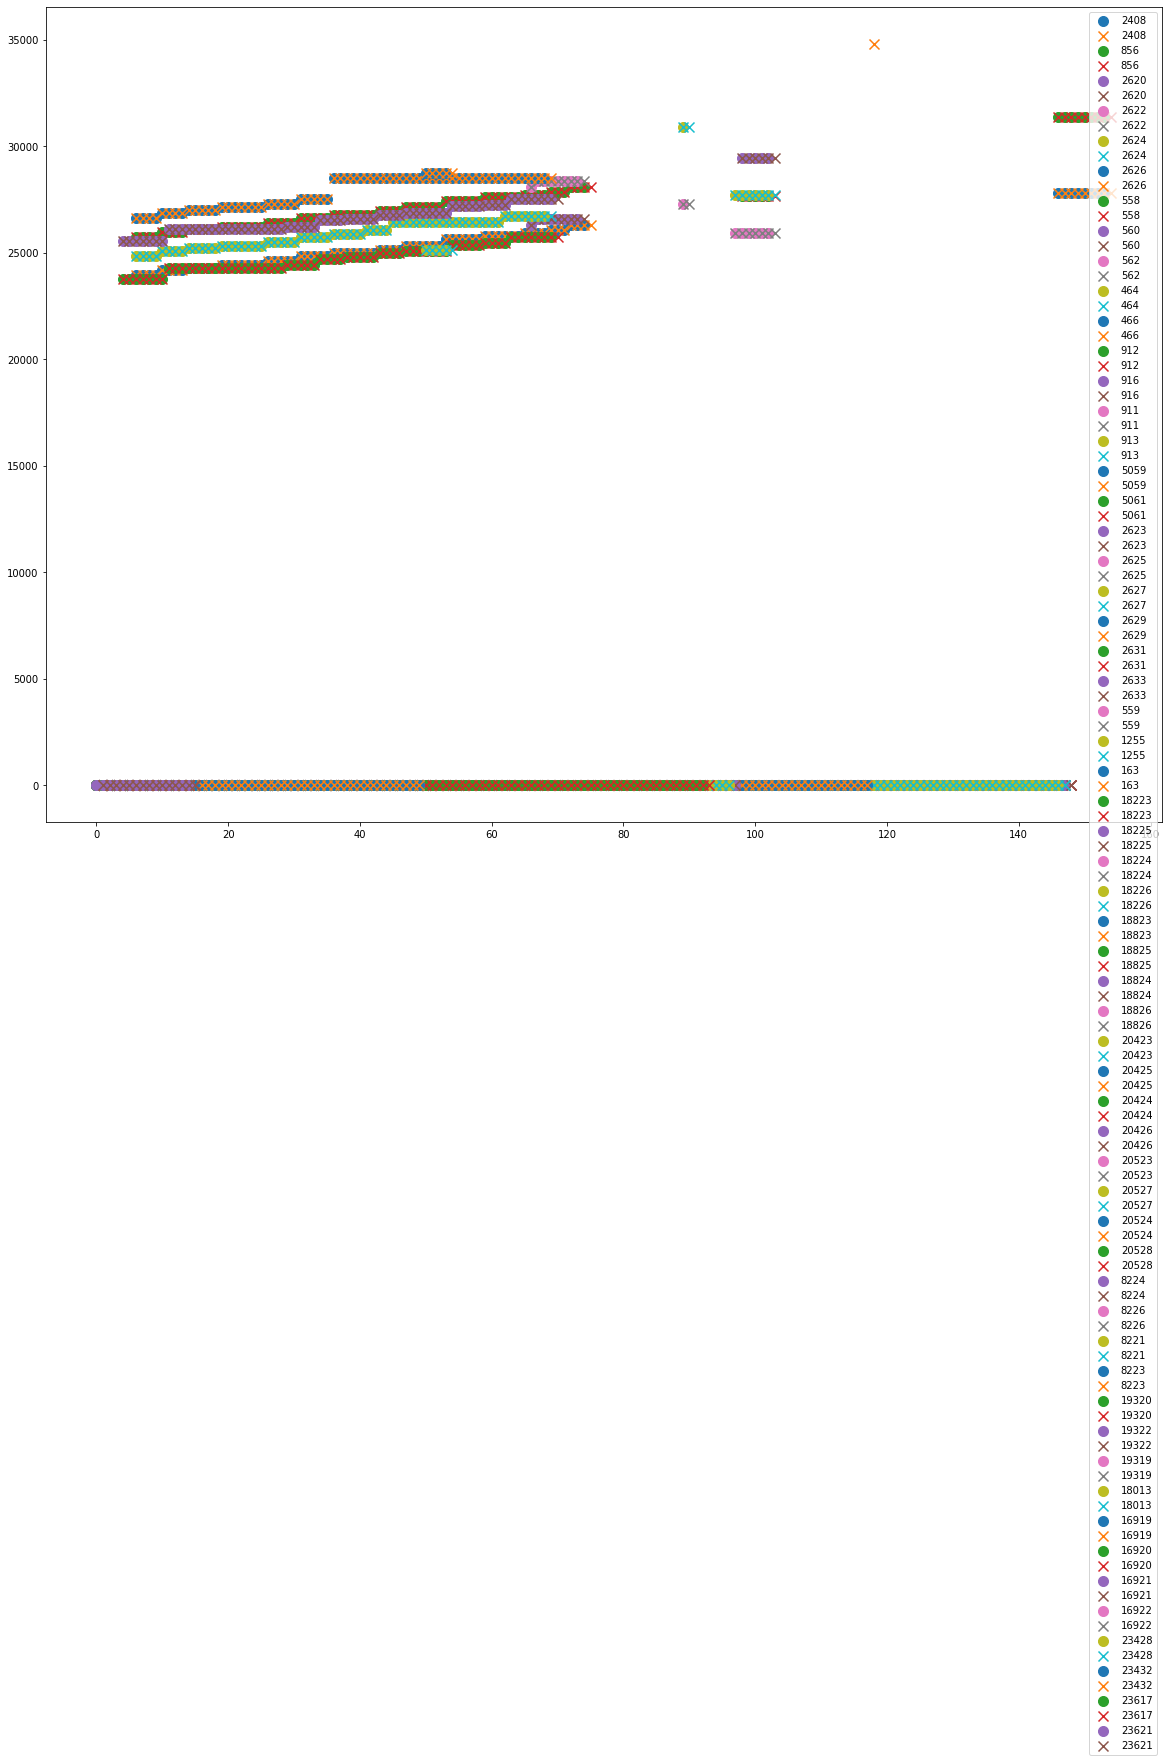

In [32]:
display_solution(x.value)

In [36]:
route_graphs[18226].edges[('(475->480)','(480->485)')]

{'edge_data': {'penalty': None,
  'minimum_running_time': 'PT10S',
  'resource_occupations': {'PF_3-A': 'PT10S', 'PF_3-B': 'PT10S'},
  'R': 10,
  'section_marker': 'PF_Halt',
  'start_end': None,
  'min_stopping_time': 'PT24S',
  'entry_latest': '07:09:00',
  'exit_earliest': '07:08:00',
  'entry_delay_weight': 1,
  'sequence_number': 480}}

In [84]:
non_binary = []
for i in range(total_length):
    if i not in bool_idx:
        non_binary.append(i)

In [85]:
#def solve_mosek(At, b, bool_idx):
from mosek.fusion import *
import sys

with Model() as M:
    

    x = M.variable('x',  total_length  , Domain.greaterThan(0.0))#Domain.binary())

    for idx in bool_idx:
        x.index(idx).makeInteger()
        M.constraint(x.index(idx), Domain.lessThan(1.5))
    M.constraint('c1', Expr.mul(At, x), Domain.lessThan(bt))
    print(x.getShape())
    # Set the objective function to (c^T * x)
    M.objective('obj', ObjectiveSense.Minimize, Expr.dot(c, x))

    # Assign values to integer variables.
    # We only set a slice of xx
    #init_sol = [1.0, 1.0, 0.0]
    #x.slice(0,3).setLevel(init_sol)

    # Solve the problem
    M.setLogHandler(sys.stdout)
    M.solve()

    # Get the solution values
    ss = M.getPrimalSolutionStatus()
    print("Solution status: {0}".format(ss))
    sol = x.level()
    print('x = {0}'.format(sol))

    # Was the initial solution used?
    constr = M.getSolverIntInfo("mioConstructSolution")
    constrVal = M.getSolverDoubleInfo("mioConstructSolutionObj")
    print("Initial solution utilization: {0}\nInitial solution objective: {1:.3f}\n".format(constr, constrVal))    

ValueError: Invalid argument list mul(<245424x60054 sparse matrix of type '<class 'numpy.float64'>'
	with 1120265 stored elements in COOrdinate format>,mosek.fusion.LinearVariable). Candidates are
	mosek.fusion.Expr.mul(mosek.fusion.Expression,array(double,ndim=1))
	mosek.fusion.Expr.mul(mosek.fusion.Matrix,mosek.fusion.Variable)
	mosek.fusion.Expr.mul(array(double,ndim=1),mosek.fusion.Expression)
	mosek.fusion.Expr.mul(double,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Matrix,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,mosek.fusion.Parameter)
	mosek.fusion.Expr.mul(mosek.fusion.Variable,mosek.fusion.Matrix)
	mosek.fusion.Expr.mul(mosek.fusion.Parameter,mosek.fusion.Expression)
	mosek.fusion.Expr.mul(array(double,ndim=2),mosek.fusion.Expression)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,mosek.fusion.Matrix)
	mosek.fusion.Expr.mul(mosek.fusion.Expression,array(double,ndim=2))
	mosek.fusion.Expr.mul(mosek.fusion.Expression,double)

In [ ]:
sol

In [83]:
j=0
con=9
for i in bool_idx:
    if j == con:
        j=0
        print('----')
        if con==9:
            con=14
        else:
            con=9
    j+=1
    print(sol[i], x.value[i])

AttributeError: 'LinearVariable' object has no attribute 'value'

In [59]:
x_star = x.value
g = A_coup@x_star-b_coup
np.linalg.norm(g,2)

8540536.510722203

In [64]:
lam = np.zeros(len(b_coup))
errors = []
xvals = []
for i in range(100):

    bool_vars_idx = [(x,) for x in bool_idx]

    x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

    p = cp.Problem(cp.Minimize(c.T@x - lam.T@(A_coup@x - b_coup) ),
                     [A@x<=b])
    p = p.solve(solver = 'MOSEK', verbose = False)

    
    x = x.value
    xvals.append(x)
    
    g = A_coup@x-b_coup
    errors.append(np.linalg.norm(g,2))

    bool_vars_idx = [(x,) for x in bool_idx]

    lam = cp.Variable(len(b_coup))

    p = cp.Problem(cp.Maximize(lam.T@(A_coup@x - b_coup) ),
                     [lam >=0, c.T + lam.T@A_coup >=0])
    p = p.solve(solver = 'MOSEK', verbose = False)
    
    lam = lam.value



In [65]:
vecerrors = np.array([np.linalg.norm(v-x_star,2) for v in xvals])
vecerrors/=max(vecerrors)
errors = np.array(errors)
errors /= max(errors)

In [67]:
err

1.0

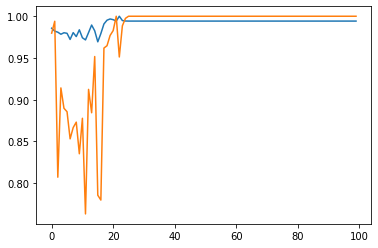

In [68]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.plot(vecerrors)

In [101]:
x = cp.Variable(A_coup.shape[1], boolean = bool_vars_idx)
p = cp.Problem(cp.Minimize(c.T@x) ,
                 [A_coup@x<=b_coup])
p = p.solve(solver = 'MOSEK', verbose = True)

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 22 05:57:40 PM: Your problem has 318 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 22 05:57:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 22 05:57:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 22 05:57:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 22 05:57:40 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 22 05:57:40 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [95]:
lam = np.zeros(len(b_coup))
A=np.vstack((A,A_coup))
b = np.hstack((b, b_coup))
bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

p = cp.Problem(cp.Minimize(c.T@x),
                 [A@x<=b])
p.solve(solver = 'MOSEK', verbose = True)

lam = cp.Variable(len(b))

d = cp.Problem(cp.Maximize(-b.T@lam),
                 [A.T@lam + c ==0, lam >=0 ])
d.solve(solver = 'MOSEK', verbose = True)

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 22 05:51:37 PM: Your problem has 318 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 22 05:51:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 22 05:51:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 22 05:51:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 22 05:51:37 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 22 05:51:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

5   3.0e+01  1.5e-02  3.2e+04  6.91e-01   -3.720513116e+06  3.323155675e+06   7.6e-02  0.05  
6   4.5e+00  2.4e-03  4.9e+03  9.50e-01   -1.560262945e+05  9.479865290e+05   1.2e-02  0.05  
7   3.1e+00  1.6e-03  3.3e+03  9.62e-01   -6.644324296e+04  6.888489522e+05   7.9e-03  0.05  
8   1.3e+00  6.7e-04  1.4e+03  1.01e+00   -1.030638939e+05  2.138819354e+05   3.3e-03  0.06  
9   1.7e-01  9.0e-05  1.9e+02  9.92e-01   -1.384968459e+04  2.860609979e+04   4.5e-04  0.06  
10  1.0e-03  5.2e-07  1.1e+00  9.99e-01   -7.877029750e+01  1.663728601e+02   2.6e-06  0.06  
11  5.2e-06  2.7e-09  5.6e-03  1.00e+00   -4.125941954e-01  8.715614228e-01   1.3e-08  0.06  
12  2.8e-08  1.6e-09  2.6e-04  1.00e+00   -2.169849300e-03  5.759014757e-02   7.1e-11  0.07  
13  1.4e-10  8.6e-12  1.4e-06  1.00e+00   -1.128102493e-05  3.051679560e-04   3.7e-13  0.07  
14  1.4e-12  3.6e-14  4.2e-09  1.00e+00   -5.864993643e-08  -1.012804992e-06  1.9e-15  0.07  
15  1.4e-12  3.6e-14  4.2e-09  1.99e+02   -5.864993643e-08  

5.265563076765421e-09

In [93]:
bool_vars_idx = [(x,) for x in bool_idx]

lam = np.ones(len(b_coup))
max_iter = 10000
tolerance = 0.5
x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

lb = -np.inf
ub = np.inf
currbest = ub
error = []
j= 0 
divider=2
z=100
for i in range(max_iter):
    print('iteration',i)
    #print('solving decoupled', i)
    #x = cp.Variable(A.shape[1], boolean = bool_vars_idx)
    #p_sub = cp.Problem(cp.Minimize(c.T@x),
    #             [A@x<=b])
    #print(lam)
    #z = p_sub.solve(solver = 'MOSEK', verbose = True)    
    #x = x.value

    #print('solving dual', i)
    #d = cp.Problem(cp.Maximize( -np.hstack((b,b_coup)).T@lam ),
    #         [np.vstack((A,A_coup)).T@lam +c == 0, lam>=0])
    
    #d_star = d.solve(solver = 'MOSEK', verbose = True) 
    #print('solving relaxed', i)
    #lam = cp.Variable(len(b_coup))
    x = cp.Variable(A.shape[1], boolean = bool_vars_idx)
    r = cp.Problem(cp.Minimize(c.T@x +  lam.T@(A_coup@x -b_coup) ),
                 [A@x<=b])
    try:
        z = r.solve(solver = 'MOSEK', verbose = False)
        print(z)
        x = x.value
        xprev = x.copy()
    except:
        lam = lamprev.copy()
        divider = divider/2
        x=xprev.copy()
        print('failed')

    g = A_coup@x-b_coup
    error.append(np.linalg.norm(g,2))
    
    if z<currbest:
        currbest = z
    else:
        if j==10:
            divider = divider/2
            j=0
        
    
    step = divider*z/np.linalg.norm(g,2)
    if np.linalg.norm(g,2)<=tolerance:
        break
    else:
        lamprev = lam.copy()
        lam = np.maximum(0,lam+g*step)
        #lam = np.round(lam)
    j+=1

iteration 0
-299996334.0
iteration 1
failed
iteration 2
failed
iteration 3
failed
iteration 4
failed
iteration 5
failed
iteration 6
failed
iteration 7
failed
iteration 8
failed
iteration 9
failed
iteration 10
failed
iteration 11
failed
iteration 12
failed
iteration 13
failed
iteration 14
failed
iteration 15
failed
iteration 16
failed
iteration 17
failed
iteration 18
failed
iteration 19
failed
iteration 20
failed
iteration 21
failed
iteration 22
failed
iteration 23
failed
iteration 24
failed
iteration 25
failed
iteration 26
failed
iteration 27
failed
iteration 28
failed
iteration 29
-304975723.58170915
iteration 30
failed
iteration 31
-306243164.7564106
iteration 32
failed
iteration 33
failed
iteration 34
failed
iteration 35
-306402253.31923306
iteration 36
failed
iteration 37
-306481838.922662
iteration 38
failed
iteration 39
failed
iteration 40
failed
iteration 41
failed
iteration 42
-306484326.6187611
iteration 43
failed
iteration 44
-306485570.4769068
iteration 45
failed
iteration 4

-306485909.7523334
iteration 277
-306485909.7523334
iteration 278
-306485909.7523334
iteration 279
-306485909.7523334
iteration 280
-306485909.7523334
iteration 281
-306485909.7523334
iteration 282
-306485909.7523334
iteration 283
-306485909.7523334
iteration 284
-306485909.7523334
iteration 285
-306485909.7523334
iteration 286
-306485909.7523334
iteration 287
-306485909.7523334
iteration 288
-306485909.7523334
iteration 289
-306485909.7523334
iteration 290
failed
iteration 291
-306485909.7523334
iteration 292
-306485909.7523334
iteration 293
-306485909.7523334
iteration 294
-306485909.7523334
iteration 295
-306485909.7523334
iteration 296
-306485909.7523334
iteration 297
-306485909.7523334
iteration 298
-306485909.7523334
iteration 299
-306485909.7523334
iteration 300
-306485909.7523334
iteration 301
-306485909.7523334
iteration 302
-306485909.7523334
iteration 303
-306485909.7523334
iteration 304
-306485909.7523334
iteration 305
-306485909.7523334
iteration 306
-306485909.7523334
ite

-306485909.7523334
iteration 528
-306485909.7523334
iteration 529
-306485909.7523334
iteration 530
-306485909.7523334
iteration 531
-306485909.7523334
iteration 532
-306485909.7523334
iteration 533
-306485909.7523334
iteration 534
-306485909.7523334
iteration 535
-306485909.7523334
iteration 536
-306485909.7523334
iteration 537
-306485909.7523334
iteration 538
-306485909.7523334
iteration 539
-306485909.7523334
iteration 540
-306485909.7523334
iteration 541
-306485909.7523334
iteration 542
-306485909.7523334
iteration 543
-306485909.7523334
iteration 544
-306485909.7523334
iteration 545
-306485909.7523334
iteration 546
-306485909.7523334
iteration 547
-306485909.7523334
iteration 548
-306485909.7523334
iteration 549
-306485909.7523334
iteration 550
-306485909.7523334
iteration 551
-306485909.7523334
iteration 552
-306485909.7523334
iteration 553
-306485909.7523334
iteration 554
-306485909.7523334
iteration 555
-306485909.7523334
iteration 556
-306485909.7523334
iteration 557
-306485909

-306485909.7523334
iteration 779
-306485909.7523334
iteration 780
-306485909.7523334
iteration 781
-306485909.7523334
iteration 782
-306485909.7523334
iteration 783
-306485909.7523334
iteration 784
-306485909.7523334
iteration 785
-306485909.7523334
iteration 786
-306485909.7523334
iteration 787
-306485909.7523334
iteration 788
-306485909.7523334
iteration 789
-306485909.7523334
iteration 790
-306485909.7523334
iteration 791
-306485909.7523334
iteration 792
-306485909.7523334
iteration 793
-306485909.7523334
iteration 794
-306485909.7523334
iteration 795
-306485909.7523334
iteration 796
-306485909.7523334
iteration 797
-306485909.7523334
iteration 798
-306485909.7523334
iteration 799
-306485909.7523334
iteration 800
-306485909.7523334
iteration 801
-306485909.7523334
iteration 802
-306485909.7523334
iteration 803
-306485909.7523334
iteration 804
-306485909.7523334
iteration 805
-306485909.7523334
iteration 806
-306485909.7523334
iteration 807
-306485909.7523334
iteration 808
-306485909

-306485909.7523334
iteration 1028
-306485909.7523334
iteration 1029
-306485909.7523334
iteration 1030
-306485909.7523334
iteration 1031
-306485909.7523334
iteration 1032
-306485909.7523334
iteration 1033
-306485909.7523334
iteration 1034
-306485909.7523334
iteration 1035
-306485909.7523334
iteration 1036
-306485909.7523334
iteration 1037
-306485909.7523334
iteration 1038
-306485909.7523334
iteration 1039
-306485909.7523334
iteration 1040
-306485909.7523334
iteration 1041
-306485909.7523334
iteration 1042
-306485909.7523334
iteration 1043
-306485909.7523334
iteration 1044
-306485909.7523334
iteration 1045
-306485909.7523334
iteration 1046
-306485909.7523334
iteration 1047
-306485909.7523334
iteration 1048
-306485909.7523334
iteration 1049
-306485909.7523334
iteration 1050
-306485909.7523334
iteration 1051
-306485909.7523334
iteration 1052
-306485909.7523334
iteration 1053
-306485909.7523334
iteration 1054
-306485909.7523334
iteration 1055
-306485909.7523334
iteration 1056
-306485909.752

-306485909.7523334
iteration 1270
-306485909.7523334
iteration 1271
-306485909.7523334
iteration 1272
-306485909.7523334
iteration 1273
-306485909.7523334
iteration 1274
-306485909.7523334
iteration 1275
-306485909.7523334
iteration 1276
-306485909.7523334
iteration 1277
-306485909.7523334
iteration 1278
-306485909.7523334
iteration 1279
-306485909.7523334
iteration 1280
-306485909.7523334
iteration 1281
-306485909.7523334
iteration 1282
-306485909.7523334
iteration 1283
-306485909.7523334
iteration 1284
-306485909.7523334
iteration 1285
-306485909.7523334
iteration 1286
-306485909.7523334
iteration 1287
-306485909.7523334
iteration 1288
-306485909.7523334
iteration 1289
-306485909.7523334
iteration 1290
-306485909.7523334
iteration 1291
-306485909.7523334
iteration 1292
-306485909.7523334
iteration 1293
-306485909.7523334
iteration 1294
-306485909.7523334
iteration 1295
-306485909.7523334
iteration 1296
-306485909.7523334
iteration 1297
-306485909.7523334
iteration 1298
-306485909.752

-306485909.7523334
iteration 1511
-306485909.7523334
iteration 1512
-306485909.7523334
iteration 1513
-306485909.7523334
iteration 1514
-306485909.7523334
iteration 1515
-306485909.7523334
iteration 1516
-306485909.7523334
iteration 1517
-306485909.7523334
iteration 1518
-306485909.7523334
iteration 1519
-306485909.7523334
iteration 1520
-306485909.7523334
iteration 1521
-306485909.7523334
iteration 1522
-306485909.7523334
iteration 1523
-306485909.7523334
iteration 1524
-306485909.7523334
iteration 1525
-306485909.7523334
iteration 1526
-306485909.7523334
iteration 1527
-306485909.7523334
iteration 1528
-306485909.7523334
iteration 1529
-306485909.7523334
iteration 1530
-306485909.7523334
iteration 1531
-306485909.7523334
iteration 1532
-306485909.7523334
iteration 1533
-306485909.7523334
iteration 1534
-306485909.7523334
iteration 1535
-306485909.7523334
iteration 1536
-306485909.7523334
iteration 1537
-306485909.7523334
iteration 1538
-306485909.7523334
iteration 1539
-306485909.752

-306485909.7523334
iteration 1753
-306485909.7523334
iteration 1754
-306485909.7523334
iteration 1755
-306485909.7523334
iteration 1756
-306485909.7523334
iteration 1757
-306485909.7523334
iteration 1758
-306485909.7523334
iteration 1759
-306485909.7523334
iteration 1760
-306485909.7523334
iteration 1761
-306485909.7523334
iteration 1762
-306485909.7523334
iteration 1763
-306485909.7523334
iteration 1764
-306485909.7523334
iteration 1765
-306485909.7523334
iteration 1766
-306485909.7523334
iteration 1767
-306485909.7523334
iteration 1768
-306485909.7523334
iteration 1769
-306485909.7523334
iteration 1770
-306485909.7523334
iteration 1771
-306485909.7523334
iteration 1772
-306485909.7523334
iteration 1773
-306485909.7523334
iteration 1774
-306485909.7523334
iteration 1775
-306485909.7523334
iteration 1776
-306485909.7523334
iteration 1777
-306485909.7523334
iteration 1778
-306485909.7523334
iteration 1779
-306485909.7523334
iteration 1780
-306485909.7523334
iteration 1781
-306485909.752

-306485909.7523334
iteration 1996
-306485909.7523334
iteration 1997
-306485909.7523334
iteration 1998
-306485909.7523334
iteration 1999
-306485909.7523334
iteration 2000
-306485909.7523334
iteration 2001
-306485909.7523334
iteration 2002
-306485909.7523334
iteration 2003
-306485909.7523334
iteration 2004
-306485909.7523334
iteration 2005
-306485909.7523334
iteration 2006
-306485909.7523334
iteration 2007
-306485909.7523334
iteration 2008
-306485909.7523334
iteration 2009
-306485909.7523334
iteration 2010
-306485909.7523334
iteration 2011
-306485909.7523334
iteration 2012
-306485909.7523334
iteration 2013
-306485909.7523334
iteration 2014
-306485909.7523334
iteration 2015
-306485909.7523334
iteration 2016
-306485909.7523334
iteration 2017
-306485909.7523334
iteration 2018
-306485909.7523334
iteration 2019
-306485909.7523334
iteration 2020
-306485909.7523334
iteration 2021
-306485909.7523334
iteration 2022
-306485909.7523334
iteration 2023
-306485909.7523334
iteration 2024
-306485909.752

-306485909.7523334
iteration 2239
-306485909.7523334
iteration 2240
-306485909.7523334
iteration 2241
-306485909.7523334
iteration 2242
-306485909.7523334
iteration 2243
-306485909.7523334
iteration 2244
-306485909.7523334
iteration 2245
-306485909.7523334
iteration 2246
-306485909.7523334
iteration 2247
-306485909.7523334
iteration 2248
-306485909.7523334
iteration 2249
-306485909.7523334
iteration 2250
-306485909.7523334
iteration 2251
-306485909.7523334
iteration 2252
-306485909.7523334
iteration 2253
-306485909.7523334
iteration 2254
-306485909.7523334
iteration 2255
-306485909.7523334
iteration 2256
-306485909.7523334
iteration 2257
-306485909.7523334
iteration 2258
-306485909.7523334
iteration 2259
-306485909.7523334
iteration 2260
-306485909.7523334
iteration 2261
-306485909.7523334
iteration 2262
-306485909.7523334
iteration 2263
-306485909.7523334
iteration 2264
-306485909.7523334
iteration 2265
-306485909.7523334
iteration 2266
-306485909.7523334
iteration 2267
-306485909.752

-306485909.7523334
iteration 2482
-306485909.7523334
iteration 2483
-306485909.7523334
iteration 2484
-306485909.7523334
iteration 2485
-306485909.7523334
iteration 2486
-306485909.7523334
iteration 2487
-306485909.7523334
iteration 2488
-306485909.7523334
iteration 2489
-306485909.7523334
iteration 2490
-306485909.7523334
iteration 2491
-306485909.7523334
iteration 2492
-306485909.7523334
iteration 2493
-306485909.7523334
iteration 2494
-306485909.7523334
iteration 2495
-306485909.7523334
iteration 2496
-306485909.7523334
iteration 2497
-306485909.7523334
iteration 2498
-306485909.7523334
iteration 2499
-306485909.7523334
iteration 2500
-306485909.7523334
iteration 2501
-306485909.7523334
iteration 2502
-306485909.7523334
iteration 2503
-306485909.7523334
iteration 2504
-306485909.7523334
iteration 2505
-306485909.7523334
iteration 2506
-306485909.7523334
iteration 2507
-306485909.7523334
iteration 2508
-306485909.7523334
iteration 2509
-306485909.7523334
iteration 2510
-306485909.752

-306485909.7523334
iteration 2723
-306485909.7523334
iteration 2724
-306485909.7523334
iteration 2725
-306485909.7523334
iteration 2726
-306485909.7523334
iteration 2727
-306485909.7523334
iteration 2728
-306485909.7523334
iteration 2729
-306485909.7523334
iteration 2730
-306485909.7523334
iteration 2731
-306485909.7523334
iteration 2732
-306485909.7523334
iteration 2733
-306485909.7523334
iteration 2734
-306485909.7523334
iteration 2735
-306485909.7523334
iteration 2736
-306485909.7523334
iteration 2737
-306485909.7523334
iteration 2738
-306485909.7523334
iteration 2739
-306485909.7523334
iteration 2740
-306485909.7523334
iteration 2741
-306485909.7523334
iteration 2742
-306485909.7523334
iteration 2743
-306485909.7523334
iteration 2744
-306485909.7523334
iteration 2745
-306485909.7523334
iteration 2746
-306485909.7523334
iteration 2747
-306485909.7523334
iteration 2748
-306485909.7523334
iteration 2749
-306485909.7523334
iteration 2750
-306485909.7523334
iteration 2751
-306485909.752

-306485909.7523334
iteration 2965
-306485909.7523334
iteration 2966
-306485909.7523334
iteration 2967
-306485909.7523334
iteration 2968
-306485909.7523334
iteration 2969
-306485909.7523334
iteration 2970
-306485909.7523334
iteration 2971
-306485909.7523334
iteration 2972
-306485909.7523334
iteration 2973
-306485909.7523334
iteration 2974
-306485909.7523334
iteration 2975
-306485909.7523334
iteration 2976
-306485909.7523334
iteration 2977
-306485909.7523334
iteration 2978
-306485909.7523334
iteration 2979
-306485909.7523334
iteration 2980
-306485909.7523334
iteration 2981
-306485909.7523334
iteration 2982
-306485909.7523334
iteration 2983
-306485909.7523334
iteration 2984
-306485909.7523334
iteration 2985
-306485909.7523334
iteration 2986
-306485909.7523334
iteration 2987
-306485909.7523334
iteration 2988
-306485909.7523334
iteration 2989
-306485909.7523334
iteration 2990
-306485909.7523334
iteration 2991
-306485909.7523334
iteration 2992
-306485909.7523334
iteration 2993
-306485909.752

-306485909.7523334
iteration 3207
-306485909.7523334
iteration 3208
-306485909.7523334
iteration 3209
-306485909.7523334
iteration 3210
-306485909.7523334
iteration 3211
-306485909.7523334
iteration 3212
-306485909.7523334
iteration 3213
-306485909.7523334
iteration 3214
-306485909.7523334
iteration 3215
-306485909.7523334
iteration 3216
-306485909.7523334
iteration 3217
-306485909.7523334
iteration 3218
-306485909.7523334
iteration 3219
-306485909.7523334
iteration 3220
-306485909.7523334
iteration 3221
-306485909.7523334
iteration 3222
-306485909.7523334
iteration 3223
-306485909.7523334
iteration 3224
-306485909.7523334
iteration 3225
-306485909.7523334
iteration 3226
-306485909.7523334
iteration 3227
-306485909.7523334
iteration 3228
-306485909.7523334
iteration 3229
-306485909.7523334
iteration 3230
-306485909.7523334
iteration 3231
-306485909.7523334
iteration 3232
-306485909.7523334
iteration 3233
-306485909.7523334
iteration 3234
-306485909.7523334
iteration 3235
-306485909.752

-306485909.7523334
iteration 3448
-306485909.7523334
iteration 3449
-306485909.7523334
iteration 3450
-306485909.7523334
iteration 3451
-306485909.7523334
iteration 3452
-306485909.7523334
iteration 3453
-306485909.7523334
iteration 3454
-306485909.7523334
iteration 3455
-306485909.7523334
iteration 3456
-306485909.7523334
iteration 3457
-306485909.7523334
iteration 3458
-306485909.7523334
iteration 3459
-306485909.7523334
iteration 3460
-306485909.7523334
iteration 3461
-306485909.7523334
iteration 3462
-306485909.7523334
iteration 3463
-306485909.7523334
iteration 3464
-306485909.7523334
iteration 3465
-306485909.7523334
iteration 3466
-306485909.7523334
iteration 3467
-306485909.7523334
iteration 3468
-306485909.7523334
iteration 3469
-306485909.7523334
iteration 3470
-306485909.7523334
iteration 3471
-306485909.7523334
iteration 3472
-306485909.7523334
iteration 3473
-306485909.7523334
iteration 3474
-306485909.7523334
iteration 3475
-306485909.7523334
iteration 3476
-306485909.752

-306485909.7523334
iteration 3690
-306485909.7523334
iteration 3691
-306485909.7523334
iteration 3692
-306485909.7523334
iteration 3693
-306485909.7523334
iteration 3694
-306485909.7523334
iteration 3695
-306485909.7523334
iteration 3696
-306485909.7523334
iteration 3697
-306485909.7523334
iteration 3698
-306485909.7523334
iteration 3699
-306485909.7523334
iteration 3700
-306485909.7523334
iteration 3701
-306485909.7523334
iteration 3702
-306485909.7523334
iteration 3703
-306485909.7523334
iteration 3704
-306485909.7523334
iteration 3705
-306485909.7523334
iteration 3706
-306485909.7523334
iteration 3707
-306485909.7523334
iteration 3708
-306485909.7523334
iteration 3709
-306485909.7523334
iteration 3710
-306485909.7523334
iteration 3711
-306485909.7523334
iteration 3712
-306485909.7523334
iteration 3713
-306485909.7523334
iteration 3714
-306485909.7523334
iteration 3715
-306485909.7523334
iteration 3716
-306485909.7523334
iteration 3717
-306485909.7523334
iteration 3718
-306485909.752

-306485909.7523334
iteration 3933
-306485909.7523334
iteration 3934
-306485909.7523334
iteration 3935
-306485909.7523334
iteration 3936
-306485909.7523334
iteration 3937
-306485909.7523334
iteration 3938
-306485909.7523334
iteration 3939
-306485909.7523334
iteration 3940
-306485909.7523334
iteration 3941
-306485909.7523334
iteration 3942
-306485909.7523334
iteration 3943
-306485909.7523334
iteration 3944
-306485909.7523334
iteration 3945
-306485909.7523334
iteration 3946
-306485909.7523334
iteration 3947
-306485909.7523334
iteration 3948
-306485909.7523334
iteration 3949
-306485909.7523334
iteration 3950
-306485909.7523334
iteration 3951
-306485909.7523334
iteration 3952
-306485909.7523334
iteration 3953
-306485909.7523334
iteration 3954
-306485909.7523334
iteration 3955
-306485909.7523334
iteration 3956
-306485909.7523334
iteration 3957
-306485909.7523334
iteration 3958
-306485909.7523334
iteration 3959
-306485909.7523334
iteration 3960
-306485909.7523334
iteration 3961
-306485909.752

-306485909.7523334
iteration 4175
-306485909.7523334
iteration 4176
-306485909.7523334
iteration 4177
-306485909.7523334
iteration 4178
-306485909.7523334
iteration 4179
-306485909.7523334
iteration 4180
-306485909.7523334
iteration 4181
-306485909.7523334
iteration 4182
-306485909.7523334
iteration 4183
-306485909.7523334
iteration 4184
-306485909.7523334
iteration 4185
-306485909.7523334
iteration 4186
-306485909.7523334
iteration 4187
-306485909.7523334
iteration 4188
-306485909.7523334
iteration 4189
-306485909.7523334
iteration 4190
-306485909.7523334
iteration 4191
-306485909.7523334
iteration 4192
-306485909.7523334
iteration 4193
-306485909.7523334
iteration 4194
-306485909.7523334
iteration 4195
-306485909.7523334
iteration 4196
-306485909.7523334
iteration 4197
-306485909.7523334
iteration 4198
-306485909.7523334
iteration 4199
-306485909.7523334
iteration 4200
-306485909.7523334
iteration 4201
-306485909.7523334
iteration 4202
-306485909.7523334
iteration 4203
-306485909.752

-306485909.7523334
iteration 4417
-306485909.7523334
iteration 4418
-306485909.7523334
iteration 4419
-306485909.7523334
iteration 4420
-306485909.7523334
iteration 4421
-306485909.7523334
iteration 4422
-306485909.7523334
iteration 4423
-306485909.7523334
iteration 4424
-306485909.7523334
iteration 4425
-306485909.7523334
iteration 4426
-306485909.7523334
iteration 4427
-306485909.7523334
iteration 4428
-306485909.7523334
iteration 4429
-306485909.7523334
iteration 4430
-306485909.7523334
iteration 4431
-306485909.7523334
iteration 4432
-306485909.7523334
iteration 4433
-306485909.7523334
iteration 4434
-306485909.7523334
iteration 4435
-306485909.7523334
iteration 4436
-306485909.7523334
iteration 4437
-306485909.7523334
iteration 4438
-306485909.7523334
iteration 4439
-306485909.7523334
iteration 4440
-306485909.7523334
iteration 4441
-306485909.7523334
iteration 4442
-306485909.7523334
iteration 4443
-306485909.7523334
iteration 4444
-306485909.7523334
iteration 4445
-306485909.752

-306485909.7523334
iteration 4660
-306485909.7523334
iteration 4661
-306485909.7523334
iteration 4662
-306485909.7523334
iteration 4663
-306485909.7523334
iteration 4664
-306485909.7523334
iteration 4665
-306485909.7523334
iteration 4666
-306485909.7523334
iteration 4667
-306485909.7523334
iteration 4668
-306485909.7523334
iteration 4669
-306485909.7523334
iteration 4670
-306485909.7523334
iteration 4671
-306485909.7523334
iteration 4672
-306485909.7523334
iteration 4673
-306485909.7523334
iteration 4674
-306485909.7523334
iteration 4675
-306485909.7523334
iteration 4676
-306485909.7523334
iteration 4677
-306485909.7523334
iteration 4678
-306485909.7523334
iteration 4679
-306485909.7523334
iteration 4680
-306485909.7523334
iteration 4681
-306485909.7523334
iteration 4682
-306485909.7523334
iteration 4683
-306485909.7523334
iteration 4684
-306485909.7523334
iteration 4685
-306485909.7523334
iteration 4686
-306485909.7523334
iteration 4687
-306485909.7523334
iteration 4688
-306485909.752

-306485909.7523334
iteration 4902
-306485909.7523334
iteration 4903
-306485909.7523334
iteration 4904
-306485909.7523334
iteration 4905
-306485909.7523334
iteration 4906
-306485909.7523334
iteration 4907
-306485909.7523334
iteration 4908
-306485909.7523334
iteration 4909
-306485909.7523334
iteration 4910
-306485909.7523334
iteration 4911
-306485909.7523334
iteration 4912
-306485909.7523334
iteration 4913
-306485909.7523334
iteration 4914
-306485909.7523334
iteration 4915
-306485909.7523334
iteration 4916
-306485909.7523334
iteration 4917
-306485909.7523334
iteration 4918
-306485909.7523334
iteration 4919
-306485909.7523334
iteration 4920
-306485909.7523334
iteration 4921
-306485909.7523334
iteration 4922
-306485909.7523334
iteration 4923
-306485909.7523334
iteration 4924
-306485909.7523334
iteration 4925
-306485909.7523334
iteration 4926
-306485909.7523334
iteration 4927
-306485909.7523334
iteration 4928
-306485909.7523334
iteration 4929
-306485909.7523334
iteration 4930
-306485909.752

-306485909.7523334
iteration 5145
-306485909.7523334
iteration 5146
-306485909.7523334
iteration 5147
-306485909.7523334
iteration 5148
-306485909.7523334
iteration 5149
-306485909.7523334
iteration 5150
-306485909.7523334
iteration 5151
-306485909.7523334
iteration 5152
-306485909.7523334
iteration 5153
-306485909.7523334
iteration 5154
-306485909.7523334
iteration 5155
-306485909.7523334
iteration 5156
-306485909.7523334
iteration 5157
-306485909.7523334
iteration 5158
-306485909.7523334
iteration 5159
-306485909.7523334
iteration 5160
-306485909.7523334
iteration 5161
-306485909.7523334
iteration 5162
-306485909.7523334
iteration 5163
-306485909.7523334
iteration 5164
-306485909.7523334
iteration 5165
-306485909.7523334
iteration 5166
-306485909.7523334
iteration 5167
-306485909.7523334
iteration 5168
-306485909.7523334
iteration 5169
-306485909.7523334
iteration 5170
-306485909.7523334
iteration 5171
-306485909.7523334
iteration 5172
-306485909.7523334
iteration 5173
-306485909.752

-306485909.7523334
iteration 5388
-306485909.7523334
iteration 5389
-306485909.7523334
iteration 5390
-306485909.7523334
iteration 5391
-306485909.7523334
iteration 5392
-306485909.7523334
iteration 5393
-306485909.7523334
iteration 5394
-306485909.7523334
iteration 5395
-306485909.7523334
iteration 5396
-306485909.7523334
iteration 5397
-306485909.7523334
iteration 5398
-306485909.7523334
iteration 5399
-306485909.7523334
iteration 5400
-306485909.7523334
iteration 5401
-306485909.7523334
iteration 5402
-306485909.7523334
iteration 5403
-306485909.7523334
iteration 5404
-306485909.7523334
iteration 5405
-306485909.7523334
iteration 5406
-306485909.7523334
iteration 5407
-306485909.7523334
iteration 5408
-306485909.7523334
iteration 5409
-306485909.7523334
iteration 5410
-306485909.7523334
iteration 5411
-306485909.7523334
iteration 5412
-306485909.7523334
iteration 5413
-306485909.7523334
iteration 5414
-306485909.7523334
iteration 5415
-306485909.7523334
iteration 5416
-306485909.752

-306485909.7523334
iteration 5630
-306485909.7523334
iteration 5631
-306485909.7523334
iteration 5632
-306485909.7523334
iteration 5633
-306485909.7523334
iteration 5634
-306485909.7523334
iteration 5635
-306485909.7523334
iteration 5636
-306485909.7523334
iteration 5637
-306485909.7523334
iteration 5638
-306485909.7523334
iteration 5639
-306485909.7523334
iteration 5640
-306485909.7523334
iteration 5641
-306485909.7523334
iteration 5642
-306485909.7523334
iteration 5643
-306485909.7523334
iteration 5644
-306485909.7523334
iteration 5645
-306485909.7523334
iteration 5646
-306485909.7523334
iteration 5647
-306485909.7523334
iteration 5648
-306485909.7523334
iteration 5649
-306485909.7523334
iteration 5650
-306485909.7523334
iteration 5651
-306485909.7523334
iteration 5652
-306485909.7523334
iteration 5653
-306485909.7523334
iteration 5654
-306485909.7523334
iteration 5655
-306485909.7523334
iteration 5656
-306485909.7523334
iteration 5657
-306485909.7523334
iteration 5658
-306485909.752

-306485909.7523334
iteration 5872
-306485909.7523334
iteration 5873
-306485909.7523334
iteration 5874
-306485909.7523334
iteration 5875
-306485909.7523334
iteration 5876
-306485909.7523334
iteration 5877
-306485909.7523334
iteration 5878
-306485909.7523334
iteration 5879
-306485909.7523334
iteration 5880
-306485909.7523334
iteration 5881
-306485909.7523334
iteration 5882
-306485909.7523334
iteration 5883
-306485909.7523334
iteration 5884
-306485909.7523334
iteration 5885
-306485909.7523334
iteration 5886
-306485909.7523334
iteration 5887
-306485909.7523334
iteration 5888
-306485909.7523334
iteration 5889
-306485909.7523334
iteration 5890
-306485909.7523334
iteration 5891
-306485909.7523334
iteration 5892
-306485909.7523334
iteration 5893
-306485909.7523334
iteration 5894
-306485909.7523334
iteration 5895
-306485909.7523334
iteration 5896
-306485909.7523334
iteration 5897
-306485909.7523334
iteration 5898
-306485909.7523334
iteration 5899
-306485909.7523334
iteration 5900
-306485909.752

-306485909.7523334
iteration 6113
-306485909.7523334
iteration 6114
-306485909.7523334
iteration 6115
-306485909.7523334
iteration 6116
-306485909.7523334
iteration 6117
-306485909.7523334
iteration 6118
-306485909.7523334
iteration 6119
-306485909.7523334
iteration 6120
-306485909.7523334
iteration 6121
-306485909.7523334
iteration 6122
-306485909.7523334
iteration 6123
-306485909.7523334
iteration 6124
-306485909.7523334
iteration 6125
-306485909.7523334
iteration 6126
-306485909.7523334
iteration 6127
-306485909.7523334
iteration 6128
-306485909.7523334
iteration 6129
-306485909.7523334
iteration 6130
-306485909.7523334
iteration 6131
-306485909.7523334
iteration 6132
-306485909.7523334
iteration 6133
-306485909.7523334
iteration 6134
-306485909.7523334
iteration 6135
-306485909.7523334
iteration 6136
-306485909.7523334
iteration 6137
-306485909.7523334
iteration 6138
-306485909.7523334
iteration 6139
-306485909.7523334
iteration 6140
-306485909.7523334
iteration 6141
-306485909.752

-306485909.7523334
iteration 6355
-306485909.7523334
iteration 6356
-306485909.7523334
iteration 6357
-306485909.7523334
iteration 6358
-306485909.7523334
iteration 6359
-306485909.7523334
iteration 6360
-306485909.7523334
iteration 6361
-306485909.7523334
iteration 6362
-306485909.7523334
iteration 6363
-306485909.7523334
iteration 6364
-306485909.7523334
iteration 6365
-306485909.7523334
iteration 6366
-306485909.7523334
iteration 6367
-306485909.7523334
iteration 6368
-306485909.7523334
iteration 6369
-306485909.7523334
iteration 6370
-306485909.7523334
iteration 6371
-306485909.7523334
iteration 6372
-306485909.7523334
iteration 6373
-306485909.7523334
iteration 6374
-306485909.7523334
iteration 6375
-306485909.7523334
iteration 6376
-306485909.7523334
iteration 6377
-306485909.7523334
iteration 6378
-306485909.7523334
iteration 6379
-306485909.7523334
iteration 6380
-306485909.7523334
iteration 6381
-306485909.7523334
iteration 6382
-306485909.7523334
iteration 6383
-306485909.752

-306485909.7523334
iteration 6598
-306485909.7523334
iteration 6599
-306485909.7523334
iteration 6600
-306485909.7523334
iteration 6601
-306485909.7523334
iteration 6602
-306485909.7523334
iteration 6603
-306485909.7523334
iteration 6604
-306485909.7523334
iteration 6605
-306485909.7523334
iteration 6606
-306485909.7523334
iteration 6607
-306485909.7523334
iteration 6608
-306485909.7523334
iteration 6609
-306485909.7523334
iteration 6610
-306485909.7523334
iteration 6611
-306485909.7523334
iteration 6612
-306485909.7523334
iteration 6613
-306485909.7523334
iteration 6614
-306485909.7523334
iteration 6615
-306485909.7523334
iteration 6616
-306485909.7523334
iteration 6617
-306485909.7523334
iteration 6618
-306485909.7523334
iteration 6619
-306485909.7523334
iteration 6620
-306485909.7523334
iteration 6621
-306485909.7523334
iteration 6622
-306485909.7523334
iteration 6623
-306485909.7523334
iteration 6624
-306485909.7523334
iteration 6625
-306485909.7523334
iteration 6626
-306485909.752

-306485909.7523334
iteration 6840
-306485909.7523334
iteration 6841
-306485909.7523334
iteration 6842
-306485909.7523334
iteration 6843
-306485909.7523334
iteration 6844
-306485909.7523334
iteration 6845
-306485909.7523334
iteration 6846
-306485909.7523334
iteration 6847
-306485909.7523334
iteration 6848
-306485909.7523334
iteration 6849
-306485909.7523334
iteration 6850
-306485909.7523334
iteration 6851
-306485909.7523334
iteration 6852
-306485909.7523334
iteration 6853
-306485909.7523334
iteration 6854
-306485909.7523334
iteration 6855
-306485909.7523334
iteration 6856
-306485909.7523334
iteration 6857
-306485909.7523334
iteration 6858
-306485909.7523334
iteration 6859
-306485909.7523334
iteration 6860
-306485909.7523334
iteration 6861
-306485909.7523334
iteration 6862
-306485909.7523334
iteration 6863
-306485909.7523334
iteration 6864
-306485909.7523334
iteration 6865
-306485909.7523334
iteration 6866
-306485909.7523334
iteration 6867
-306485909.7523334
iteration 6868
-306485909.752

-306485909.7523334
iteration 7081
-306485909.7523334
iteration 7082
-306485909.7523334
iteration 7083
-306485909.7523334
iteration 7084
-306485909.7523334
iteration 7085
-306485909.7523334
iteration 7086
-306485909.7523334
iteration 7087
-306485909.7523334
iteration 7088
-306485909.7523334
iteration 7089
-306485909.7523334
iteration 7090
-306485909.7523334
iteration 7091
-306485909.7523334
iteration 7092
-306485909.7523334
iteration 7093
-306485909.7523334
iteration 7094
-306485909.7523334
iteration 7095
-306485909.7523334
iteration 7096
-306485909.7523334
iteration 7097
-306485909.7523334
iteration 7098
-306485909.7523334
iteration 7099
-306485909.7523334
iteration 7100
-306485909.7523334
iteration 7101
-306485909.7523334
iteration 7102
-306485909.7523334
iteration 7103
-306485909.7523334
iteration 7104
-306485909.7523334
iteration 7105
-306485909.7523334
iteration 7106
-306485909.7523334
iteration 7107
-306485909.7523334
iteration 7108
-306485909.7523334
iteration 7109
-306485909.752

-306485909.7523334
iteration 7324
-306485909.7523334
iteration 7325
-306485909.7523334
iteration 7326
-306485909.7523334
iteration 7327
-306485909.7523334
iteration 7328
-306485909.7523334
iteration 7329
-306485909.7523334
iteration 7330
-306485909.7523334
iteration 7331
-306485909.7523334
iteration 7332
-306485909.7523334
iteration 7333
-306485909.7523334
iteration 7334
-306485909.7523334
iteration 7335
-306485909.7523334
iteration 7336
-306485909.7523334
iteration 7337
-306485909.7523334
iteration 7338
-306485909.7523334
iteration 7339
-306485909.7523334
iteration 7340
-306485909.7523334
iteration 7341
-306485909.7523334
iteration 7342
-306485909.7523334
iteration 7343
-306485909.7523334
iteration 7344
-306485909.7523334
iteration 7345
-306485909.7523334
iteration 7346
-306485909.7523334
iteration 7347
-306485909.7523334
iteration 7348
-306485909.7523334
iteration 7349
-306485909.7523334
iteration 7350
-306485909.7523334
iteration 7351
-306485909.7523334
iteration 7352
-306485909.752

-306485909.7523334
iteration 7565
-306485909.7523334
iteration 7566
-306485909.7523334
iteration 7567
-306485909.7523334
iteration 7568
-306485909.7523334
iteration 7569
-306485909.7523334
iteration 7570
-306485909.7523334
iteration 7571
-306485909.7523334
iteration 7572
-306485909.7523334
iteration 7573
-306485909.7523334
iteration 7574
-306485909.7523334
iteration 7575
-306485909.7523334
iteration 7576
-306485909.7523334
iteration 7577
-306485909.7523334
iteration 7578
-306485909.7523334
iteration 7579
-306485909.7523334
iteration 7580
-306485909.7523334
iteration 7581
-306485909.7523334
iteration 7582
-306485909.7523334
iteration 7583
-306485909.7523334
iteration 7584
-306485909.7523334
iteration 7585
-306485909.7523334
iteration 7586
-306485909.7523334
iteration 7587
-306485909.7523334
iteration 7588
-306485909.7523334
iteration 7589
-306485909.7523334
iteration 7590
-306485909.7523334
iteration 7591
-306485909.7523334
iteration 7592
-306485909.7523334
iteration 7593
-306485909.752

-306485909.7523334
iteration 7808
-306485909.7523334
iteration 7809
-306485909.7523334
iteration 7810
-306485909.7523334
iteration 7811
-306485909.7523334
iteration 7812
-306485909.7523334
iteration 7813
-306485909.7523334
iteration 7814
-306485909.7523334
iteration 7815
-306485909.7523334
iteration 7816
-306485909.7523334
iteration 7817
-306485909.7523334
iteration 7818
-306485909.7523334
iteration 7819
-306485909.7523334
iteration 7820
-306485909.7523334
iteration 7821
-306485909.7523334
iteration 7822
-306485909.7523334
iteration 7823
-306485909.7523334
iteration 7824
-306485909.7523334
iteration 7825
-306485909.7523334
iteration 7826
-306485909.7523334
iteration 7827
-306485909.7523334
iteration 7828
-306485909.7523334
iteration 7829
-306485909.7523334
iteration 7830
-306485909.7523334
iteration 7831
-306485909.7523334
iteration 7832
-306485909.7523334
iteration 7833
-306485909.7523334
iteration 7834
-306485909.7523334
iteration 7835
-306485909.7523334
iteration 7836
-306485909.752

-306485909.7523334
iteration 8050
-306485909.7523334
iteration 8051
-306485909.7523334
iteration 8052
-306485909.7523334
iteration 8053
-306485909.7523334
iteration 8054
-306485909.7523334
iteration 8055
-306485909.7523334
iteration 8056
-306485909.7523334
iteration 8057
-306485909.7523334
iteration 8058
-306485909.7523334
iteration 8059
-306485909.7523334
iteration 8060
-306485909.7523334
iteration 8061
-306485909.7523334
iteration 8062
-306485909.7523334
iteration 8063
-306485909.7523334
iteration 8064
-306485909.7523334
iteration 8065
-306485909.7523334
iteration 8066
-306485909.7523334
iteration 8067
-306485909.7523334
iteration 8068
-306485909.7523334
iteration 8069
-306485909.7523334
iteration 8070
-306485909.7523334
iteration 8071
-306485909.7523334
iteration 8072
-306485909.7523334
iteration 8073
-306485909.7523334
iteration 8074
-306485909.7523334
iteration 8075
-306485909.7523334
iteration 8076
-306485909.7523334
iteration 8077
-306485909.7523334
iteration 8078
-306485909.752

-306485909.7523334
iteration 8292
-306485909.7523334
iteration 8293
-306485909.7523334
iteration 8294
-306485909.7523334
iteration 8295
-306485909.7523334
iteration 8296
-306485909.7523334
iteration 8297
-306485909.7523334
iteration 8298
-306485909.7523334
iteration 8299
-306485909.7523334
iteration 8300
-306485909.7523334
iteration 8301
-306485909.7523334
iteration 8302
-306485909.7523334
iteration 8303
-306485909.7523334
iteration 8304
-306485909.7523334
iteration 8305
-306485909.7523334
iteration 8306
-306485909.7523334
iteration 8307
-306485909.7523334
iteration 8308
-306485909.7523334
iteration 8309
-306485909.7523334
iteration 8310
-306485909.7523334
iteration 8311
-306485909.7523334
iteration 8312
-306485909.7523334
iteration 8313
-306485909.7523334
iteration 8314
-306485909.7523334
iteration 8315
-306485909.7523334
iteration 8316
-306485909.7523334
iteration 8317
-306485909.7523334
iteration 8318
-306485909.7523334
iteration 8319
-306485909.7523334
iteration 8320
-306485909.752

-306485909.7523334
iteration 8533
-306485909.7523334
iteration 8534
-306485909.7523334
iteration 8535
-306485909.7523334
iteration 8536
-306485909.7523334
iteration 8537
-306485909.7523334
iteration 8538
-306485909.7523334
iteration 8539
-306485909.7523334
iteration 8540
-306485909.7523334
iteration 8541
-306485909.7523334
iteration 8542
-306485909.7523334
iteration 8543
-306485909.7523334
iteration 8544
-306485909.7523334
iteration 8545
-306485909.7523334
iteration 8546
-306485909.7523334
iteration 8547
-306485909.7523334
iteration 8548
-306485909.7523334
iteration 8549
-306485909.7523334
iteration 8550
-306485909.7523334
iteration 8551
-306485909.7523334
iteration 8552
-306485909.7523334
iteration 8553
-306485909.7523334
iteration 8554
-306485909.7523334
iteration 8555
-306485909.7523334
iteration 8556
-306485909.7523334
iteration 8557
-306485909.7523334
iteration 8558
-306485909.7523334
iteration 8559
-306485909.7523334
iteration 8560
-306485909.7523334
iteration 8561
-306485909.752

-306485909.7523334
iteration 8775
-306485909.7523334
iteration 8776
-306485909.7523334
iteration 8777
-306485909.7523334
iteration 8778
-306485909.7523334
iteration 8779
-306485909.7523334
iteration 8780
-306485909.7523334
iteration 8781
-306485909.7523334
iteration 8782
-306485909.7523334
iteration 8783
-306485909.7523334
iteration 8784
-306485909.7523334
iteration 8785
-306485909.7523334
iteration 8786
-306485909.7523334
iteration 8787
-306485909.7523334
iteration 8788
-306485909.7523334
iteration 8789
-306485909.7523334
iteration 8790
-306485909.7523334
iteration 8791
-306485909.7523334
iteration 8792
-306485909.7523334
iteration 8793
-306485909.7523334
iteration 8794
-306485909.7523334
iteration 8795
-306485909.7523334
iteration 8796
-306485909.7523334
iteration 8797
-306485909.7523334
iteration 8798
-306485909.7523334
iteration 8799
-306485909.7523334
iteration 8800
-306485909.7523334
iteration 8801
-306485909.7523334
iteration 8802
-306485909.7523334
iteration 8803
-306485909.752

-306485909.7523334
iteration 9016
-306485909.7523334
iteration 9017
-306485909.7523334
iteration 9018
-306485909.7523334
iteration 9019
-306485909.7523334
iteration 9020
-306485909.7523334
iteration 9021
-306485909.7523334
iteration 9022
-306485909.7523334
iteration 9023
-306485909.7523334
iteration 9024
-306485909.7523334
iteration 9025
-306485909.7523334
iteration 9026
-306485909.7523334
iteration 9027
-306485909.7523334
iteration 9028
-306485909.7523334
iteration 9029
-306485909.7523334
iteration 9030
-306485909.7523334
iteration 9031
-306485909.7523334
iteration 9032
-306485909.7523334
iteration 9033
-306485909.7523334
iteration 9034
-306485909.7523334
iteration 9035
-306485909.7523334
iteration 9036
-306485909.7523334
iteration 9037
-306485909.7523334
iteration 9038
-306485909.7523334
iteration 9039
-306485909.7523334
iteration 9040
-306485909.7523334
iteration 9041
-306485909.7523334
iteration 9042
-306485909.7523334
iteration 9043
-306485909.7523334
iteration 9044
-306485909.752

-306485909.7523334
iteration 9259
-306485909.7523334
iteration 9260
-306485909.7523334
iteration 9261
-306485909.7523334
iteration 9262
-306485909.7523334
iteration 9263
-306485909.7523334
iteration 9264
-306485909.7523334
iteration 9265
-306485909.7523334
iteration 9266
-306485909.7523334
iteration 9267
-306485909.7523334
iteration 9268
-306485909.7523334
iteration 9269
-306485909.7523334
iteration 9270
-306485909.7523334
iteration 9271
-306485909.7523334
iteration 9272
-306485909.7523334
iteration 9273
-306485909.7523334
iteration 9274
-306485909.7523334
iteration 9275
-306485909.7523334
iteration 9276
-306485909.7523334
iteration 9277
-306485909.7523334
iteration 9278
-306485909.7523334
iteration 9279
-306485909.7523334
iteration 9280
-306485909.7523334
iteration 9281
-306485909.7523334
iteration 9282
-306485909.7523334
iteration 9283
-306485909.7523334
iteration 9284
-306485909.7523334
iteration 9285
-306485909.7523334
iteration 9286
-306485909.7523334
iteration 9287
-306485909.752

-306485909.7523334
iteration 9501
-306485909.7523334
iteration 9502
-306485909.7523334
iteration 9503
-306485909.7523334
iteration 9504
-306485909.7523334
iteration 9505
-306485909.7523334
iteration 9506
-306485909.7523334
iteration 9507
-306485909.7523334
iteration 9508
-306485909.7523334
iteration 9509
-306485909.7523334
iteration 9510
-306485909.7523334
iteration 9511
-306485909.7523334
iteration 9512
-306485909.7523334
iteration 9513
-306485909.7523334
iteration 9514
-306485909.7523334
iteration 9515
-306485909.7523334
iteration 9516
-306485909.7523334
iteration 9517
-306485909.7523334
iteration 9518
-306485909.7523334
iteration 9519
-306485909.7523334
iteration 9520
-306485909.7523334
iteration 9521
-306485909.7523334
iteration 9522
-306485909.7523334
iteration 9523
-306485909.7523334
iteration 9524
-306485909.7523334
iteration 9525
-306485909.7523334
iteration 9526
-306485909.7523334
iteration 9527
-306485909.7523334
iteration 9528
-306485909.7523334
iteration 9529
-306485909.752

-306485909.7523334
iteration 9743
-306485909.7523334
iteration 9744
-306485909.7523334
iteration 9745
-306485909.7523334
iteration 9746
-306485909.7523334
iteration 9747
-306485909.7523334
iteration 9748
-306485909.7523334
iteration 9749
-306485909.7523334
iteration 9750
-306485909.7523334
iteration 9751
-306485909.7523334
iteration 9752
-306485909.7523334
iteration 9753
-306485909.7523334
iteration 9754
-306485909.7523334
iteration 9755
-306485909.7523334
iteration 9756
-306485909.7523334
iteration 9757
-306485909.7523334
iteration 9758
-306485909.7523334
iteration 9759
-306485909.7523334
iteration 9760
-306485909.7523334
iteration 9761
-306485909.7523334
iteration 9762
-306485909.7523334
iteration 9763
-306485909.7523334
iteration 9764
-306485909.7523334
iteration 9765
-306485909.7523334
iteration 9766
-306485909.7523334
iteration 9767
-306485909.7523334
iteration 9768
-306485909.7523334
iteration 9769
-306485909.7523334
iteration 9770
-306485909.7523334
iteration 9771
-306485909.752

-306485909.7523334
iteration 9984
-306485909.7523334
iteration 9985
-306485909.7523334
iteration 9986
-306485909.7523334
iteration 9987
-306485909.7523334
iteration 9988
-306485909.7523334
iteration 9989
-306485909.7523334
iteration 9990
-306485909.7523334
iteration 9991
-306485909.7523334
iteration 9992
-306485909.7523334
iteration 9993
-306485909.7523334
iteration 9994
-306485909.7523334
iteration 9995
-306485909.7523334
iteration 9996
-306485909.7523334
iteration 9997
-306485909.7523334
iteration 9998
-306485909.7523334
iteration 9999
-306485909.7523334


In [84]:
r.objective.value

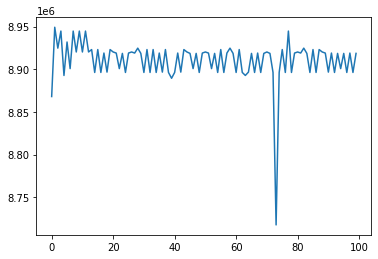

In [60]:
plt.plot(error)

### Solver

### Lagrangian relaxation

In [52]:
A = A.astype(float)
A[A.nonzero()]=1
from matplotlib import pyplot as plt
(x,y) = A.shape
S=5
plt.figure(figsize = (S,int(S*x/y)))
plt.imshow(A, cmap='Greys',  interpolation='nearest')

TypeError: 'coo_matrix' object does not support item assignment

### Constraint check